# 2.4 Схема проекта с отложенной выборкой (разбиением на train test)

Что будем делать:
- получим данные
- сформируем тренировочный и тестовый датасеты
- обучим модель
- оценим результат

## Загрузка данных

In [1]:
import pandas as pd

df = pd.read_csv("data/house_prices.csv")

## Обзор данных

In [2]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [3]:
df.shape

(20000, 9)

## Выделение матрицы объект-признак и целевой переменной

In [4]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

## Разбиение выборки на тренировочную и тестовую части

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Обучение модели на тренировочных данных

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

## Предсказание модели на тестовых данных

In [7]:
prediction = model.predict(X_test)

In [8]:
prediction[:10]

array([  3634.54014458, 212458.46103117, 278501.95085509,  70041.88004124,
       304070.89408959, 131388.86314898, 132069.04298238, 415036.94795881,
       356753.34288174, 196207.91156302])

## Вычисление метрики MSE на тестовых данных

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

mean_squared_error(y_test, prediction)

4807903806.065217

In [10]:
mean_squared_error(y_test, prediction) ** 0.5

69339.04964783709

In [11]:
print(f'{mean_absolute_percentage_error(y_test, prediction):.2f}')

0.30


# 2.6 Разведочный анализ данных

Это задание посвящено изучению данных и построению различных визуализаций.  
Наша цель - провести **разведочный анализ данных**, чтобы исследовать поведение данных и выявить в них закономерности.

Мы будем работать с датассетом пассажиров [Титаника](https://en.wikipedia.org/wiki/Titanic).

Классическая задача, решаемая на этих данных: предсказать, выжил пассажир или нет по его характеристикам.  
То есть целевая переменная - столбец `Survived`.

Цели:
* познакомиться с библиотекой `seaborn`
* научиться делать различные визуализации
* заполнять пропуски в данных
* делать однофакторный анализ
* конструировать новые признаки

Бонус:
* придумаем свою модель на основе проведенного анализа и оценим ее качество.

## Подключение библиотек и загрузка данных

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

Фиксируем `random_state` для воспроизводимости случайных значений.

In [13]:
RANDOM_STATE = 42

Загрузим данные.

In [14]:
Data = pd.read_csv("data/titanik.csv", sep=";")

**Описание признаков**

- `Survived` — выжил данный пассажир или нет (*0* для умерших, *1* для выживших)
- `Pclass` — класс пассажира (*1* — высший, *2* — средний, *3* — низший)
- `Name` — имя
- `Sex` — пол
- `Age` — возраст
- `SibSp` — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника
- `Parch` — количество родителей, детей (в том числе приемных) на борту титаника
- `Ticket` — номер билета
- `Fare` — плата за проезд
- `Cabin` — каюта
- `Embarked` — порт посадки (*C* — Шербур; *Q* — Квинстаун; *S* — Саутгемптон)

## Обзор данных

Посмотрим на *5* случайных объектов из датасета.

In [15]:
Data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
698,699,0,1,Thayer; Mr. John Borland,male,49.0,1,1,17421,110.8833,C68,C
703,704,0,3,Gallagher; Mr. Martin,male,25.0,0,0,36864,7.7417,NaN,Q
604,605,1,1,"Homer; Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,C
709,710,1,3,"Moubarek; Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
449,450,1,1,Peuchen; Major. Arthur Godfrey,male,52.0,0,0,113786,30.5000,C104,S


Выведите на экран размеры таблицы *Data*.

**Вопрос:** сколько объектов в данных?

In [16]:
len(Data)

891

## Обработка признаков и однофакторный анализ

На данном этапе:

1) Найдем признаки, у которых есть пропущенные значения и обработаем эти пропущенные значения

2) Переведём категориальные признаки в числовые

Выведем на экран основные числовые характеристики числовых столбцов.  
Это можно сделать при помощи функции `describe`.

In [17]:
Data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


В строке *count* отображается количество непропущенных значений в каждом столбце.

Основные статистики можно посмотреть и по категориальным колонкам.  
Для этого в функцию `describe` нужно передать аргумент `include='object'`.

Сделайте это.

In [18]:
Data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,3,681,147,3
top,Dooley; Mr. Patrick,male,347082,G6,S
freq,1,574,7,4,644


In [19]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [20]:
Data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Вопрос:** в скольких категориальных колонках есть пропуски?

In [21]:
categorical = []
for col in Data.columns:
    if Data[col].dtype == object:
        categorical.append(col)
res = 0
for col in categorical:
    if Data[col].isna().sum() > 0:
        res += 1
print(res)

2


### Столбец Sex

В столбце пол (`Sex`) три различных значения. Посмотрим на них.

In [22]:
Data['Sex'].value_counts()

Sex
male       574
female     312
unknown      5
Name: count, dtype: int64

Удалим пассажиров неизвестного пола, так как их всего *5*.

In [23]:
Data = Data[Data['Sex'] != 'unknown']

Проверьте, что строки с неизвестным полом исчезли.

In [24]:
display(Data['Sex'].describe())
Data['Sex'].unique()

count      886
unique       2
top       male
freq       574
Name: Sex, dtype: object

array(['male', 'female'], dtype=object)

Признак `Sex` является категориальным, то есть содержит нечисловые значения. Для работы большинства алгоритмов необходимо переводить категории в числа.

Закодировать значения столбца с двумя категориями можно следующим образом. Пусть в воображаемом столбце *animal* есть два значения: *cat* и *dog*. Их можно перевести в *0* и *1* при помощи функции `map`:

`Data['animal'] = Data['animal'].map({'cat' : 1, 'dog' : 0})`


По аналогии закодируйте столбец `Sex` (*male* - *1*, *female* - *0*).

In [25]:
Data['Sex'] = Data['Sex'].map({'male': 1, 'female': 0})

**Вопрос** посчитайте сумму значений в закодированном столбце `Sex`.

In [26]:
Data['Sex'].sum()

np.int64(574)

Посмотрим, как влияет пол на выживаемость.

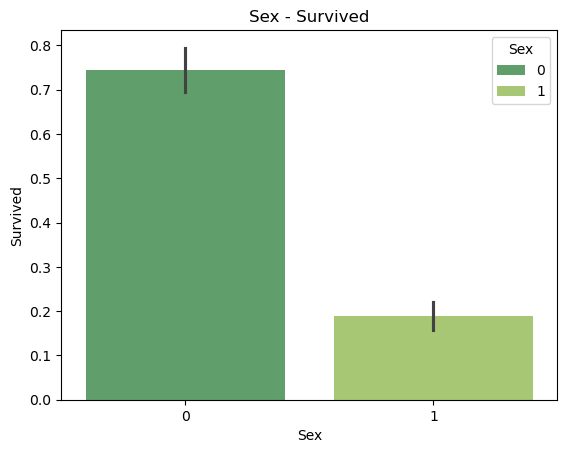

In [27]:
sns.barplot(x='Sex', y='Survived', data=Data, hue='Sex', palette='summer')
plt.title('Sex - Survived')
plt.show();

Гистограмму можно детализировать, добавив значение параметра `hue`.

### Столбец Pclass

Нарисуйте гистограмму выживаемости в зависимости от `Pclass`.  
Используйте `barplot`.

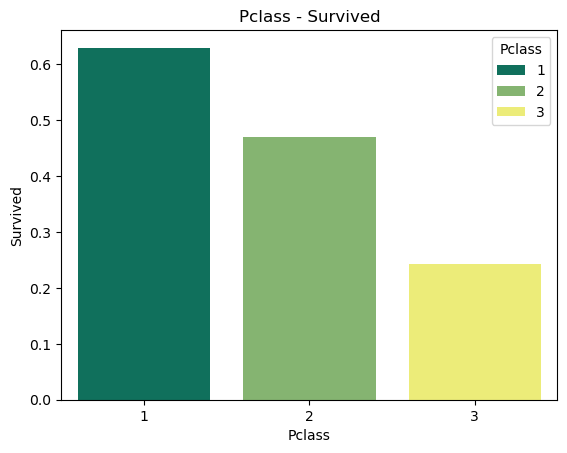

In [28]:
sns.barplot(data=Data, x='Pclass', y='Survived', hue='Pclass', palette='summer', errorbar=None)
plt.title('Pclass - Survived')
plt.show();

**Вопрос:** пассажиры из какого класса выживали чаще всего?

Посмотрим, как влияет пол человека и класс билета (`Pclass`) на выживаемость

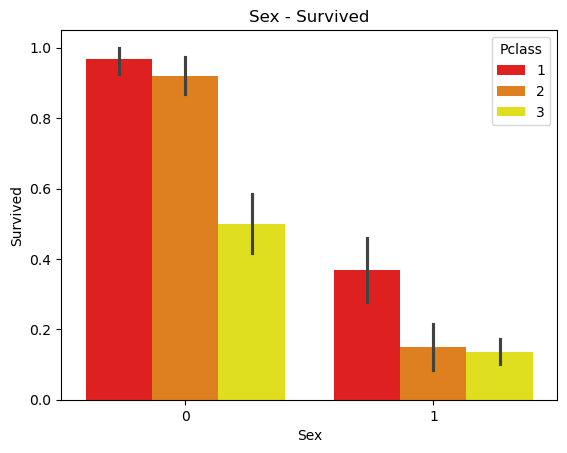

In [29]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=Data, palette='autumn')
plt.title('Sex - Survived')
plt.show();

### Столбец Embarked

**Вопрос** сколько различных значений принимает признак `Embarked`?

In [30]:
Data['Embarked'].nunique()

3

Пока что мы не обсуждали, как переводить в числа категориальные признаки с больше, чем двумя категориями.  
Поэтому давайте отбросим этот признак.

Сделайте это (вам пригодится метод [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)).

In [31]:
del Data['Embarked']

In [32]:
Data.shape

(886, 11)

### Столбец Age

Обработаем признак `Age`.

Мы помним, что в этом признаке много пропусков.

Заполним пропуски медианным значением `Age`.

In [33]:
median_age = Data['Age'].median()

Data['Age'] = Data['Age'].fillna(median_age)

Нарисуем распределение возраста пассажиров.

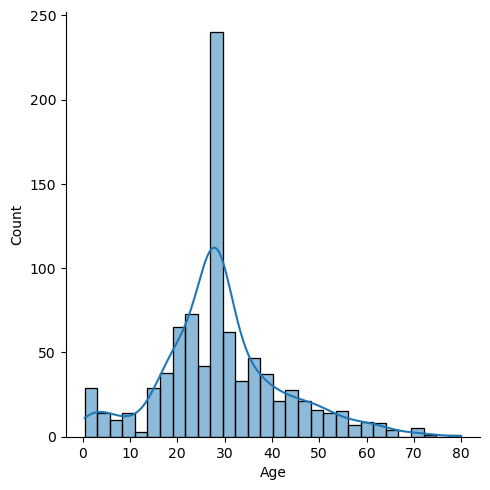

In [34]:
sns.displot(Data['Age'], kde=True)
plt.show();

### Другие столбцы

Удалите признак `Fare`. Он сильно связан с признаком `Pclass`, поэтому нам не нужен.

In [35]:
Data = Data.drop('Fare', axis=1)

**Вопрос:** сколько на данный момент колонок в таблице `Data`?

Столбец `PassengerId` является категориальным и не несёт важной информации, удалите его.

Столбцы `Ticket`, `Name` и `Cabin` в этот раз нам также не понадобятся. Удалите и их.

In [36]:
Data.drop(columns=['PassengerId', 'Ticket', 'Name', 'Cabin'], inplace=True)

После минимальной обработки данных у нас получилась следующая таблица:

In [37]:
Data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0


## Исследование признаков

Нарисуйте матрицу корреляций столбцов между собой.

In [38]:
Data.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch
Survived,1.000000,-0.338447,-0.545547,-0.062245,-0.033743,0.085753
Pclass,-0.338447,1.000000,0.133972,-0.342216,0.083148,0.015606
Sex,-0.545547,0.133972,1.000000,0.081486,-0.114677,-0.259232
Age,-0.062245,-0.342216,0.081486,1.000000,-0.235465,-0.177241
SibSp,-0.033743,0.083148,-0.114677,-0.235465,1.000000,0.422104
Parch,0.085753,0.015606,-0.259232,-0.177241,0.422104,1.000000


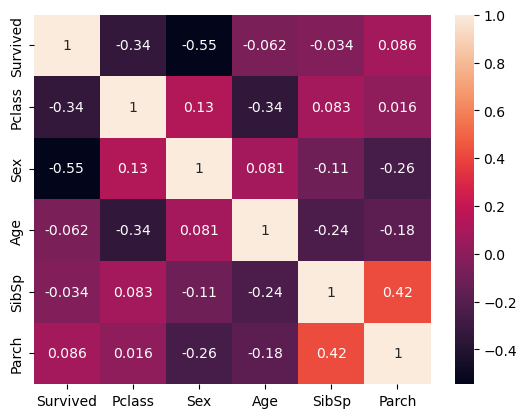

In [39]:
sns.heatmap(data=Data.corr(), annot=True)
plt.show();

**Вопрос:** какой столбец сильнее всего коррелирует с целевой переменной `Survived`?

Посмотрим на попарные зависимости некоторых признаков.

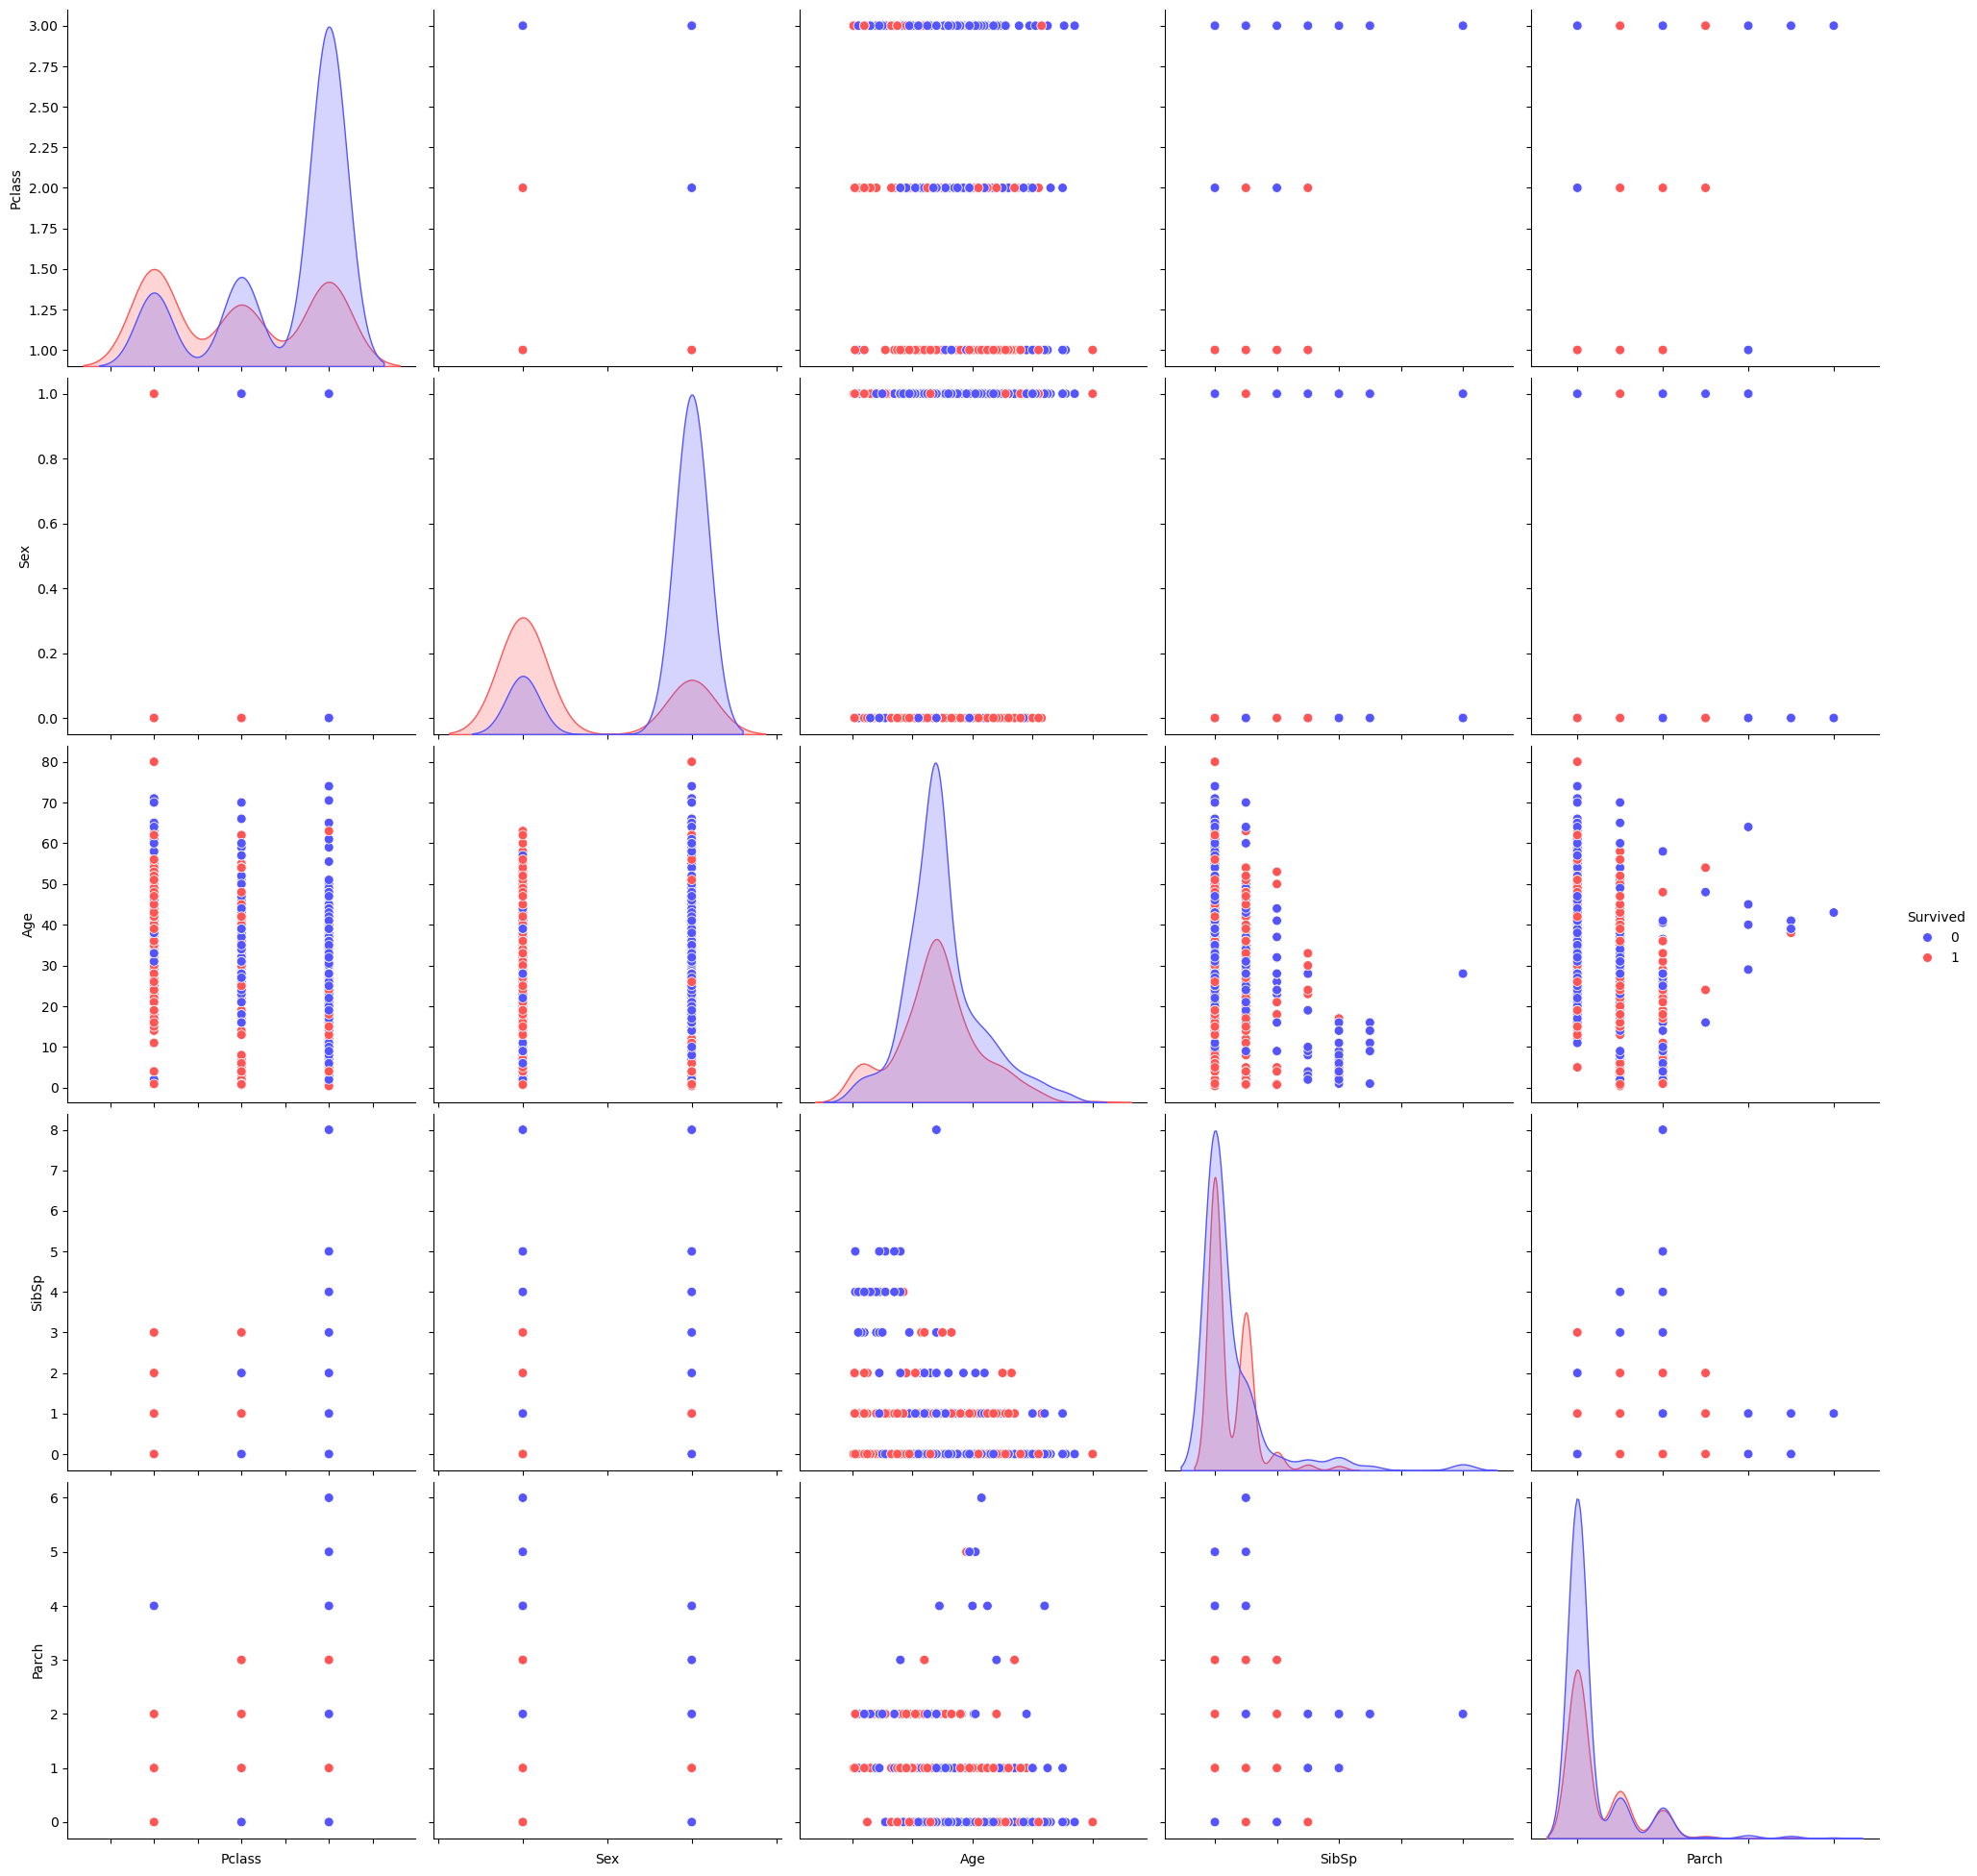

In [40]:
g = sns.pairplot(
    Data,
    hue='Survived',
    palette = 'seismic',
    height=4,
    diag_kind = 'kde',
    diag_kws=dict(fill=True),
    plot_kws=dict(s=50)
    )

g.set(xticklabels=[]);

## Бонус (не проверяется)

Мы не используем всю информацию о данных, в частности, не используем текстовые данные. Также из матрицы корреляций мы видим, что признаки `Parch` и `SibSp` слабо коррелируют с выживаемостью (`Survived`). Можно сконструировать новые признаки, чтобы решить эти вопросы.

Попробуйте сделать следующее.

1) Создайте признак `NameLen` и запишите в него длину имени (`Name`).

2) Создайте признак `FamilySize`, равный *Parch + SibSp + 1*. Зачем добавлять 1?

3) Создайте признак `IsAlone`, который показывает, путешествовал человек один или с семьей.

In [41]:
Data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0


In [42]:
# ваш код здесь

Посмотрите, как коррелируют новые признаки со столбцом `Survived`.

In [43]:
# ваш код здесь

Можно извлечь и другую полезную информацию из данных путём конструирования новых признаков.

Придумайте ещё новые осмысленные признаки. Проверьте, как они коррелируют с выживаемостью.

In [44]:
# ваш код здесь

Мы провели  однофакторный анализ данных и увидели, какие признаки сильно влияют на выживаемость, а какие нет.

Мы видим, что больше всего на выживаемость влияет пол пассажира.


### Наша собственная модель

Напишем свою модель, предсказывающую выживаемость только по признаку `Sex`.

In [45]:
def prediction(x):
    if x.Sex == 1:
        return 0
    return 1

Посчитаем долю правильных ответов нашей модели.

In [46]:
from sklearn.metrics import accuracy_score

pred = Data.apply(lambda x: prediction(x), axis=1)

accuracy_score(Data['Survived'], pred)

0.7878103837471784

# 2.7  Домашнее задание - 1

## Описание задачи и загрузка данных

В этом задании вам нужно обучить линейную регрессию для предсказания стоимости домов в Калифорнии.

Загружаем необходимые библиотеки.

In [47]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing

Фиксируем `random_state` для воспроизводимости случайных значений.

In [48]:
RANDOM_STATE = 42

Загрузим данные и сформируем из них матрицу объект-признак `X` и вектор `y`, содержащий целевую переменную.

In [49]:
Data = fetch_california_housing(as_frame=True)

X = Data['data']
y = Data['target']

Посмотрим первые пять записей набора данных.

In [50]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## Задание 1

 Сколько строк и столбцов в матрице `X`?

In [51]:
X.shape

(20640, 8)

Посмотрим на зависимость стоимости домов (целевой переменной `y`) от признака `MedInc` (`Median Income`).
Для этого можно нарисовать диаграмму рассеяния.

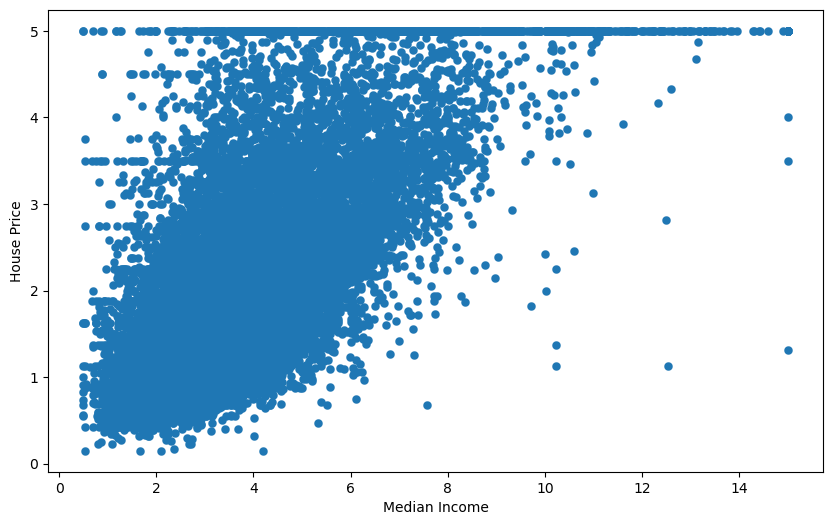

In [52]:
plt.figure(figsize=[10, 6])
plt.scatter(X['MedInc'], y, linewidths=0.1)
plt.xlabel('Median Income')
plt.ylabel('House Price')
plt.show();

По диаграмме видно, что чем больше `Median Income`, тем больше `House Price`, то есть видна прямая зависимость целевой переменной от признака `MedInc`.

## Задание 2

Постройте диаграмму рассеяния, отображающую зависимость целевой переменной от признака `Latitude`.
Какая это зависимость?

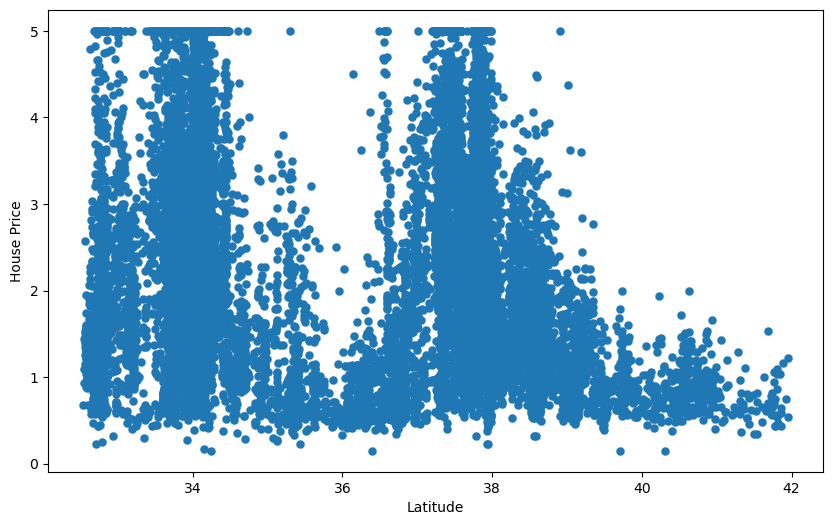

In [53]:
plt.figure(figsize=[10, 6])
plt.scatter(X['Latitude'], y, linewidths=0.1)
plt.xlabel('Latitude')
plt.ylabel('House Price')
plt.show();

Ещё немного поисследуем данные. Полноценный разведочный анализ в рамках этого задания, конечно, не провести, но какие-то инструменты мы потрогаем.

Давайте построим тепловую карту корреляций.

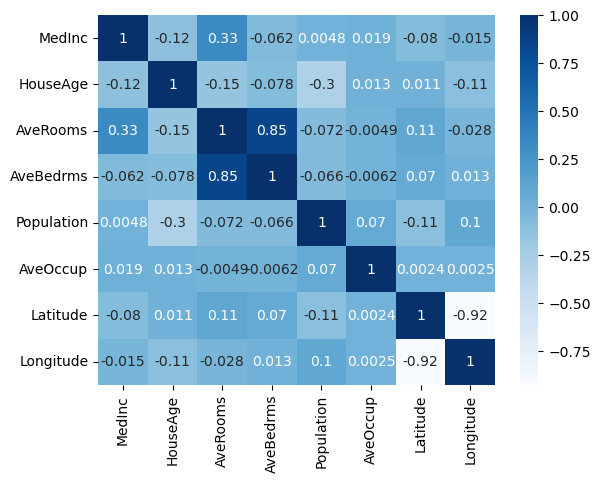

In [54]:
corr = X.corr()
sb.heatmap(corr, cmap="Blues", annot=True);

По этой матрице корреляций видно, что два наиболее зависимых признака - это `AveRooms` и `AveBedrms`.

Но интереснее посмотреть, какой признак имеет наибольшую корреляцию с целевой переменной!

## Задание 3

Добавьте к матрице `X` столбец `y` и постройте матрицу корреляций.
Какой признак имеет наибольшую по модулю корреляцию с таргетом?
После выполнения задания удалите добавленный столбец `y` из матрицы `X`.

In [55]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


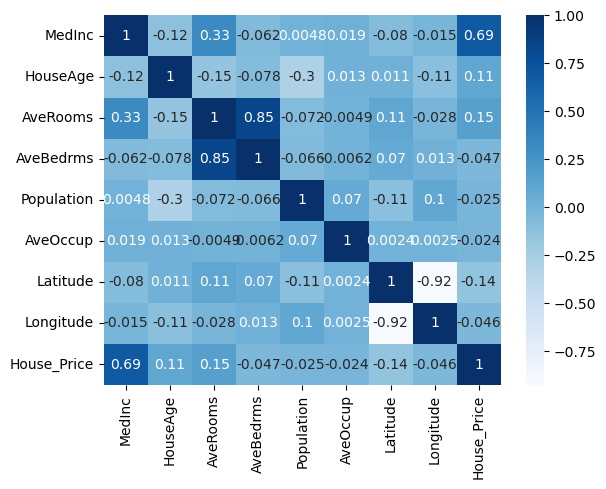

In [56]:
df = X.copy()
df.insert(df.shape[1], 'House_Price', y)
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)
plt.show();

In [57]:
df.corr().sort_values('House_Price')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,House_Price
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
House_Price,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


Разбейте данные на тренировочную и тестовую часть (в тест отправьте 25% данных).

In [58]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25)

##Задание 4

Сколько объектов попали в тест?

In [59]:
Xtest.shape

(5160, 8)

Обучите линейную регрессию с параметрами по умолчанию на тренировочных данных и сделайте предсказание на тестовых данных.

In [60]:
# ваш код здесь
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
linreg_model.fit(Xtrain, ytrain)

LinearRegression()

In [61]:
# ваш код здесь
ypred = linreg_model.predict(Xtest)
ypred[:10]

array([1.77927808, 2.6992964 , 1.83751091, 1.70154491, 0.97253517,
       1.1130148 , 2.48755244, 1.25218432, 1.51411067, 2.30015027])

## Задание 5

Вычислите значение метрики *MSE* на тестовых данных.
Ответ округлите до десятых.

In [62]:
from sklearn.metrics import mean_squared_error

round(mean_squared_error(ytest, ypred), 1)

0.5

# 3.1 Линейная регрессия

Будем решать задачу регрессии - предсказывать стоимость домов в Калифорнии.

In [63]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing

Загрузим данные.

In [64]:
Data = fetch_california_housing(as_frame=True)

X = Data['data']
y = Data['target']

In [65]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [66]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Обучим модель линейной регрессии на исходных данных.

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25)

In [68]:
model = LinearRegression()

model.fit(Xtrain, ytrain)

pred = model.predict(Xtest)

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

mean_squared_error(ytest, pred) ** 0.5

0.7276558294612105

In [70]:
mean_absolute_percentage_error(ytest, pred)

0.32549656622651946

In [71]:
r2_score(ytest, pred)

0.5974862884991816

Добавим полиномиальные признаки второй степени:

$$1, x_1, x_2 \to 1, x_1, x_2, x_1^2, x_2^2, x_1x_2.$$

In [72]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree = 2)

pf.fit(Xtrain)

Xtrain_new = pf.transform(Xtrain)
Xtest_new = pf.transform(Xtest)

In [73]:
Xtrain_new[:1].shape

(1, 45)

Обучим на обогащенных признаках модель.

In [74]:
model.fit(Xtrain_new, ytrain)

pred2 = model.predict(Xtest_new)

In [75]:
mean_squared_error(ytest, pred2) ** 0.5

0.7273071800891631

In [76]:
mean_absolute_percentage_error(ytest, pred2)

0.2722771722275924

In [77]:
r2_score(ytest, pred2)

0.5978719173272844

In [78]:
Xtrain_new.shape

(15480, 45)

Ошибка уменьшилась!

# 3.6  Домашнее задание - 2

## Описание задачи и загрузка данных

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [80]:
data = pd.read_csv('data/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Посмотрим на типы столбцов.

In [81]:
data.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

## Построение модели

### Задание 1

Есть ли в наборе данных пропущенные значения? Если да, удалите их.

Также выведите на экран число пропусков в каждом столбце.

In [82]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

### Задача 2

Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)?  
Если да, то удалите их.

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [84]:
data.drop('Unnamed: 0', axis=1, inplace=True)

### Задание 3

Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются корреляции между признаками.  
Выведите матрицу корреляций между всеми вещественными признаками и целевой переменной.

Какой вещественный признак коррелирует с целевой переменной больше всего?

In [85]:
corr = data.corr(numeric_only=True)
corr.sort_values('price')

,carat,depth,table,price,x,y,z
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249


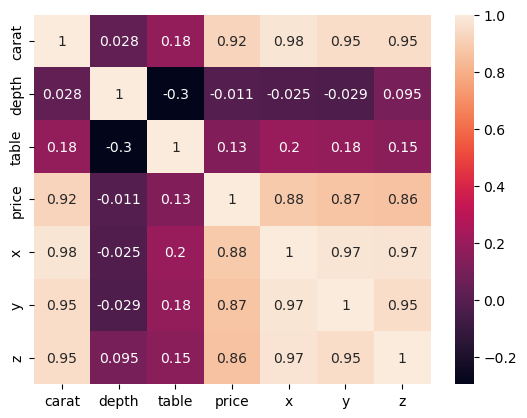

In [86]:
sns.heatmap(data=corr, annot=True)
plt.show();

### Задание 4

Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования ([`pd.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Не забудьте поставить значение параметра `drop_first` равным `True`.

Сколько получилось столбцов в таблице `data`?

*P.S. Числовые столбцы оставляем в таблице без изменений.*

In [87]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [88]:
categorical = [col for col in data.columns if data[col].dtype == 'object']
print(categorical)

data = pd.get_dummies(data=data, columns=categorical, drop_first=True)

data.head()

['cut', 'color', 'clarity']


,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False


In [89]:
data.shape

(53940, 24)

### Задание 5

Создайте матрицу `X`, содержащую все признаки, и не содержащую целевую переменную `price`. Также создайте вектор `y`, содержащий целевую переменную `price`.

In [90]:
X = data.drop('price', axis=1)
y = data['price']

Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной `0.3`.

При разбиении укажите `random_state = 42`.

In [91]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

### Задание 6

Зачастую при использовании линейных моделей вещественные признаки масштабируются.  В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

*  Обучите (`fit`) scaler на тренировочных данных
*  Преобразуйте (`transform`) и трейн, и тест

После применения масштабирования матрица перестает быть объектом `pandas.DataFrame` - решите эту проблему.

In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [93]:
scaler.fit(Xtrain)
Xtrain_scale = scaler.transform(Xtrain)
Xtest_scale = scaler.transform(Xtest)

### Задание 7

Обучите линейную регрессию на тренировочной выборке. Выведите *r2-score* на тренировочной и тестовой выборках.

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linreg_model = LinearRegression()
linreg_model.fit(Xtrain_scale, ytrain)

ypred = linreg_model.predict(Xtest_scale)

r2_score(ytest, ypred)

0.9201866914388086

### Задание 8

Выведите на экран веса, которые линейная регрессия присвоила признакам.

Какой признак имеет наибольший отрицательный вес? (наибольший по модулю среди всех отрицательных весов)

In [95]:
features = Xtrain.columns
weights = linreg_model.coef_
feature_weights = pd.DataFrame({'Feature': features, 'Weight': weights})
feature_weights.sort_values('Weight')

,Feature,Weight
3,x,-1100.418850
15,color_J,-529.449216
14,color_I,-442.783567
13,color_H,-362.002300
12,color_G,-202.863564
11,color_F,-104.560993
1,depth,-90.173817
10,color_E,-83.640021
2,table,-60.332280
5,z,-34.258945


## Попытка улучшить качество модели

Данная часть является творческой, и задания в ней немного сложнее, чем предыдущие.

Следующие вопросы не проверяются тестами.

### Задание 9

Как можно заметить из анализа корреляционной матрицы в задании 3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче, также свидетельствуют об этом. Для решения этой проблемы можно либо исключить некоторые признаки из модели (например, если признак линейно зависим с какими-то другими, его можно исключить из модели, т.е. удалить из матрицы объект-признак и заново обучить модель).

Удалите из матриц `Xtrain` и `Xtest` признак, который наиболее сильно коррелирует с остальными. Заново обучите модель и оцените её качество. Улучшилось ли качество модели?

Попробуйте удалить какой-то другой признак (можете попробовать несколько вариантов). Помогло ли это улучшить качество модели?

In [96]:
drop_col = ['y', 'table', 'depth']
Xtrain = Xtrain.drop(drop_col, axis=1)
Xtest = Xtest.drop(drop_col, axis=1)

In [97]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)

pf.fit(Xtrain)

PolynomialFeatures()

In [98]:
Xtrain_new = pf.transform(Xtrain)
Xtest_new = pf.transform(Xtest)

In [99]:
scaler = StandardScaler()
scaler.fit(Xtrain_new, ytrain)
Xtrain_scale = scaler.transform(Xtrain_new)
Xtest_scale = scaler.transform(Xtest_new)

In [100]:
linreg_model.fit(Xtrain_scale, ytrain)

ypred = linreg_model.predict(Xtest_scale)
r2_score(ypred, ytest)

0.9681130853544161

In [101]:
features = Xtrain.columns
weights = linreg_model.coef_[0]
feature_weights = pd.DataFrame({'Feature': features, 'Weight': weights})
feature_weights.sort_values('Weight')

,Feature,Weight
0,carat,-2.076017e-13
1,x,-2.076017e-13
2,z,-2.076017e-13
3,cut_Good,-2.076017e-13
4,cut_Ideal,-2.076017e-13
5,cut_Premium,-2.076017e-13
6,cut_Very Good,-2.076017e-13
7,color_E,-2.076017e-13
8,color_F,-2.076017e-13
9,color_G,-2.076017e-13


### Задание 10

Иногда генерация новых признаков помогает модели лучше находить взаимосвязи между целевой переменной и признаками. Попробуйте придумать новые признаки и добавить их в модель.  

Помогло ли это улучшить качество модели?

# 4.1 Градиентный спуск для функции одной переменной

## Импорт библиотек

In [102]:
import numpy as np
from matplotlib import pyplot as plt

## Практика

Найдем локальный минимум функции $f(x)=x^3-5x+2$ методом градиентного спуска.

Сначала определим функцию.

In [103]:
def f(x):
   return x**3 - 5*x + 2

Построим график функции.

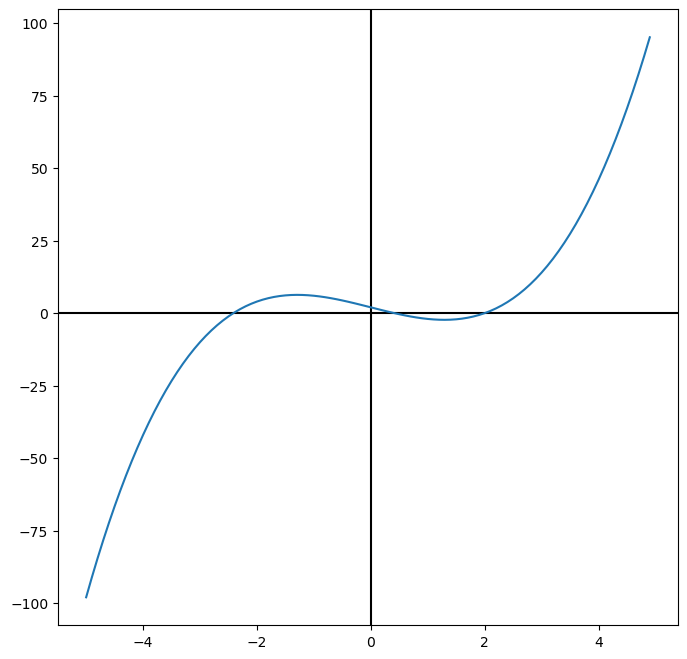

In [104]:
x_values = [x for x in np.arange(-5, 5, 0.1)]
f_values = [f(x) for x in x_values]

plt.figure(figsize=(8,8))

plt.axvline(x=0, c = 'black')
plt.axhline(y=0, c = 'black')
plt.plot(x_values, f_values)
plt.show();

Вычислим производную функции $f(x)$:

$f'(x)=3x^2-5$.



In [105]:
import sympy as sp

x = sp.Symbol('x')
fx = x**3 - 5*x + 2
fx_diff = sp.diff(fx, x)
f = sp.lambdify(x, fx_diff)
display(fx_diff)

f(2)

3*x**2 - 5

7

In [106]:
def grad_f (x):
    return 3*(x**2) - 5

Теперь реализуем метод в виде функции.

In [107]:
def gradient_descent(x_start, learning_rate, epsilon, num_iterations):
    x_curr = x_start

    for i in range(num_iterations):
      x_new = x_curr - learning_rate * grad_f(x_curr)

      if abs(x_new - x_curr) < epsilon:
        return x_curr

      x_curr = x_new

    return x_curr

Попробуем стартовать из точки $x_0 = 4$ и идти с маленьким шагом $\eta = 0.01$.

In [108]:
x0 = 4
eta = 0.01
epsilon = 0.001
iterations = 10000

x_res = gradient_descent(x0, eta, epsilon, iterations)
x_res

1.3036113611507372

Отметим найденную точку на графике.

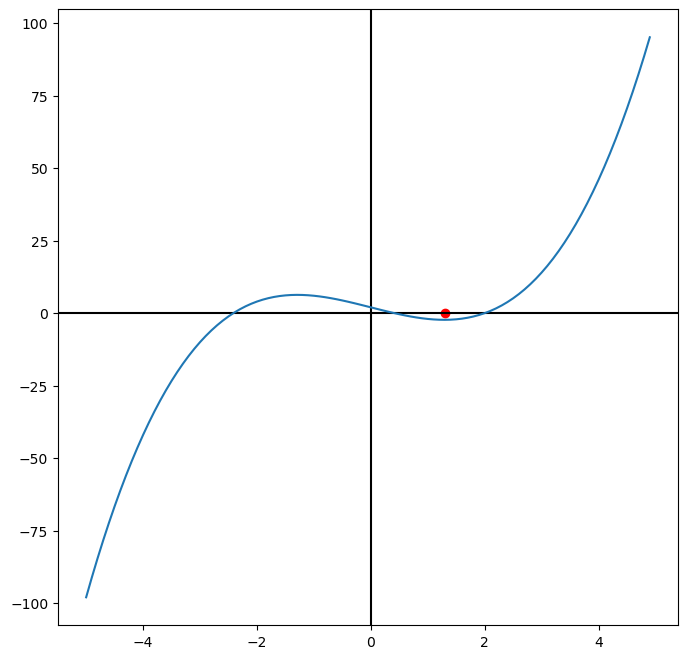

In [109]:
plt.figure(figsize=(8,8))

plt.axvline(x=0, c = 'black')
plt.axhline(y=0, c = 'black')
plt.plot(x_values, f_values)

plt.scatter(x_res, f(x_res), marker='o', c='red')
plt.show();

In [110]:
# Найдите минимум функции x**4 - 10*x + 3

# Ищите минимум с гиперпараметрами:
# x0 = 5
# n = 0.01
# epsilon = 0.001
# num_iterations = 10000

# Чему равен найденное методом значение x (локальный минимум)?
# Ответ округлите до сотых.

x0 = 5
n = 0.01
epsilon = 0.001
num_iterations = 10000

def f(x):
   return x**4 - 10*x + 3

x = sp.Symbol('x')
expr = x**4 - 10*x + 3
expr_diff = expr.diff(x)
grad_f = sp.lambdify(x, expr_diff)

def gradient_descent(x_start, step, wrong, n_iterations):
    x_curr = x_start

    for _ in range(n_iterations):
        x_new = x_curr - grad_f(x_curr) * step
        
        if abs(x_new - x_curr) < wrong:
            return x_curr
    
        x_curr = x_new

    return x_curr

res = round(gradient_descent(x0, n, epsilon, num_iterations), 2)
res

1.35

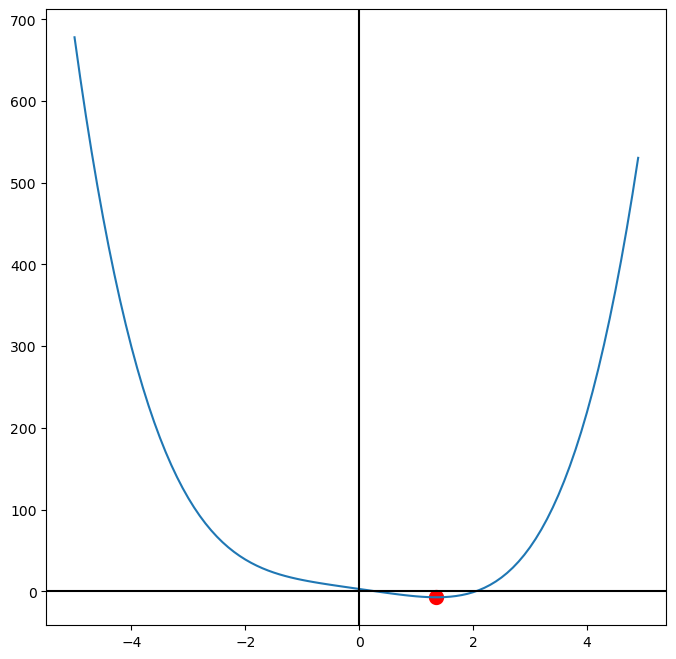

In [111]:
x_values = [x for x in np.arange(-5, 5, 0.1)]
y_values = [f(x) for x in x_values]

plt.figure(figsize=(8, 8))
plt.plot(x_values, y_values)
plt.axvline(x=0, c = 'black')
plt.axhline(y=0, c = 'black')
plt.scatter(res, f(res), marker='o', c='r', linewidths=5)

plt.show();

In [112]:
# Пусть метод стартует из точки w_start=(3,1,1). 
# Пусть шаг градиентного спуска η=0.01

# Чему будет равен вес w1 ​после одного шага градиентного спуска?
# Ответ округлите до сотых

x1 = [10, 5, 7]
x2 = [40, 36, 30]
y = [100, 73, 71]
w_start = [3, 1, 1]
n = 0.01

def grad_f(x1, x2, y, w):
    print(f'{x1} * ({w[0]} + {w[1]} * {x1} + {w[2]} * {x2} - {y})')
    print()
    return x1 * (w[0] + w[1] * x1 + w[2] * x2 - y)

def gradient_descent(x1, x2, y, w_start, step):

    Q_w = 0
    
    for i in range(len(y)):
        Q_w += grad_f(x1[i], x2[i], y[i], w_start)

    
    w1 = w_start[1] - (2 / 3 * Q_w) * step

    return w1

res = round(gradient_descent(x1, x2, y, w_start, n), 2)
res

10 * (3 + 1 * 10 + 1 * 40 - 100)

5 * (3 + 1 * 5 + 1 * 36 - 73)

7 * (3 + 1 * 7 + 1 * 30 - 71)



6.55

# 4.2 Градиентный спуск для функции нескольких переменных

## Импорт библиотек

In [113]:
import pandas as pd
import numpy as np

In [114]:
RANDOM_STATE = 42
np.random.RandomState(RANDOM_STATE);

## Практика

Создадим таблицу с обучающими данными.

In [115]:
df = pd.DataFrame({'x1' : [10, 5, 7], 'x2' : [40, 36, 30], 'y' : [100, 73, 71]})
df

,x1,x2,y
0,10,40,100
1,5,36,73
2,7,30,71


In [116]:
def prediction(w, x1, x2):
    return w[0] + w[1] * x1 + w[2] * x2

In [117]:
def grad_MSE(w, x1, x2, y):
    dw0 = (2/3) * (w[0] + w[1]*x1 + w[2]*x2 - y)
    dw1 = (2/3) * x1 * (w[0] + w[1]*x1 + w[2]*x2 - y)
    dw2 = (2/3) * x2 * (w[0] + w[1]*x1 + w[2]*x2 - y)

    return np.array([dw0, dw1, dw2])

In [118]:
grad_MSE((1, 1, 1), 10, 40, 100)

array([  -32.66666667,  -326.66666667, -1306.66666667])

In [119]:
def gradient_descent(data, w_start, learning_rate, num_iterations):
    w_curr = w_start

    for i in range(num_iterations):
      GradMSE = np.zeros(3)
      for _, row in data.iterrows():
          x1, x2, y = row
          GradMSE += grad_MSE(w_curr,x1,x2,y)

      w_new = w_curr - learning_rate * GradMSE

      w_curr = w_new

    return w_curr

In [120]:
gradient_descent(df, np.random.rand(3), 0.0001, 5000)

array([0.85462458, 3.94674806, 1.46200663])

# 4.2 Градиентный спуск для функции нескольких переменных (векторная форма)

## Импорт библиотек

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [122]:
RANDOM_STATE = 42
np.random.RandomState(RANDOM_STATE);

## Практика

Обучающие данные.

In [123]:
df = pd.DataFrame({'x1' : [10, 5, 7], 'x2' : [40, 36, 30], 'y' : [100, 73, 71]})
df

,x1,x2,y
0,10,40,100
1,5,36,73
2,7,30,71


Реализуем метод градиентного спуска для обучения линейной регрессии.

Сначала напишем функцию для вычисления среднеквадратичной ошибки

$MSE = \frac{1}{m}||Xw - y||^2_2$.

Здесь квадратичная ошибка записана в матричном виде, т.е. $X$ - матрица объект-признак, $w$ - вектор весов модели.
*  $Xw$ - вектор предсказания модели
*  $y$ - вектор правильных ответов,
и квадратичная ошибка - это квадрат нормы разности вектора предсказания и вектора правильных ответов.

Вычислить норму вектора в python можно разными способами.  
Здесь мы  воспользуемся готовой функцией из библиотеку numpy - `numpy.linalg.norm`.

In [124]:
def compute_cost(X, y, theta):
    m = len(y)

    cost = (1./m) * (np.linalg.norm(X @ theta - y) ** 2)
    return cost

Реализуем градиентный спуск по формуле

$$w_{new} = w_{prev} - \nabla_w Q(w_{prev})$$

Вычислим градиент MSE:
$$\nabla_w Q(w)=\frac2m X^T(Xw-y).$$

Итак, реализуем метод градиентного спуска:

*  первым шагом добавим к матрице `X` единичный столбец - это константный признак, равный 1 на всех объектах.  
Он нужен, чтобы записать предсказание линейной регрессии в виде скалярного произведения и тем самым избавиться от знака суммы:
$a(x)=w_0+w_1x_1+...+w_dx_d=w_1\cdot 1+w_1x_1+...w_dx_d=(w,x)$  
В python скалярное произведение можно записать так: `w@x`

*  затем инициализируем случайным образом вектор весов `params`

*  зададим пустой массив `cost_track`, в который будем записывать ошибку на каждой итерации

*  наконец, в цикле по количеству эпох (итераций) будем обновлять веса по формуле градиентного спуска

In [125]:
def gradient_descent(X, y, learning_rate, iterations):

    X = np.hstack((np.ones((X.shape[0], 1)), X)) # добавляем к Х столбец из 1
    params = np.random.rand(X.shape[1])

    m = X.shape[0]

    cost_track = np.zeros((iterations,1))

    for i in range(iterations):
        params = params - 2./m * learning_rate * (X.T @ ((X @ params) - y))
        cost_track[i] = compute_cost(X, y, params)

    return cost_track, params

Создадим функцию для получения предсказания модели

In [126]:
def predict(X, params):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ params

Применим градиентный спуск

In [127]:
track, weights = gradient_descent(df[['x1','x2']], df['y'], 0.0001, 5000)

print(weights)

[0.8077922  3.93132153 1.4665325 ]


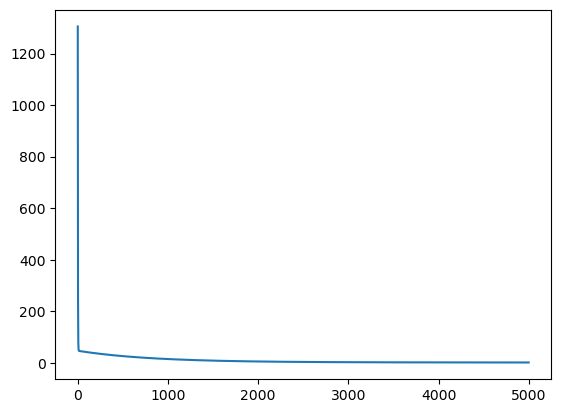

In [128]:
plt.plot(track);

# 4.3 Линейная регрессия: аналитический и численный подходы

## Импорт библиотек, установка константных значений

In [129]:
import numpy as np
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt

In [130]:
RANDOM_STATE = 42
np.random.RandomState(RANDOM_STATE);

## Постановка задачи

Сгенерируем данные для задачи регрессии

In [131]:
X, y = make_regression(n_samples=100, n_features=1, random_state=RANDOM_STATE, noise=10.0, bias=100.0)

Нарисуем сгенерированные данные

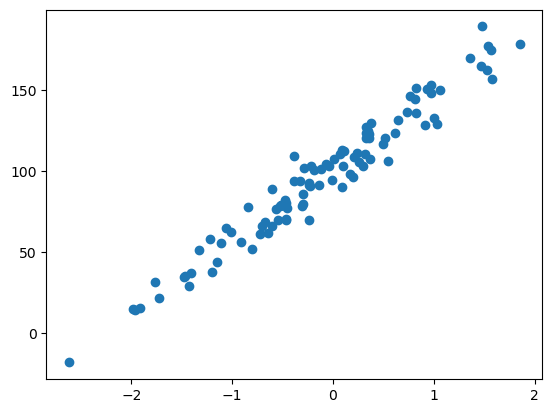

In [132]:
plt.scatter(X, y);

## Аналитический подход

Решим задачу по точной формуле
$$w = (X^TX)^{-1}X^Ty$$

In [133]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

pred_lr = lr.predict(X)

Посчитаем качество предсказания (будем использовать метрику $R^2$) и визуализируем результат.

r2: 0.9538252459635717


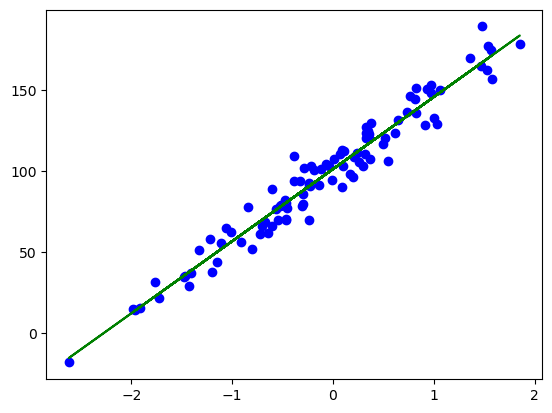

In [134]:
from sklearn.metrics import r2_score

plt.scatter(X, y, c='blue')
plt.plot(X, pred_lr, '-', c='green')

print('r2:',r2_score(y, pred_lr))

## Численный подход

Теперь обучим `SGDRegressor` и сделаем предсказание.

In [135]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd.fit(X, y)

pred_sgd = sgd.predict(X)

Добавим предсказание на график с исходными объектами и вычислим $R^2$.

r2: 0.9538240882616974


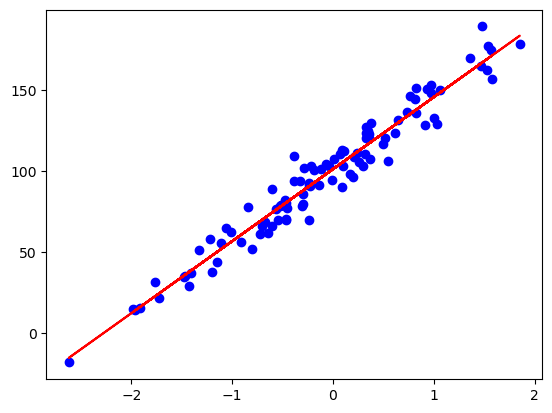

In [136]:
plt.scatter(X, y, c='blue')
plt.plot(X, pred_sgd, '-', c='red')

print('r2:',r2_score(y, pred_sgd))

Сравним качество предсказний точным и численным методами

In [137]:
print('r2 exact:',r2_score(y, pred_lr))
print('r2 numeric:',r2_score(y, pred_sgd))

r2 exact: 0.9538252459635717
r2 numeric: 0.9538240882616974


Численный подход дает чуть меньшее значение метрики качества, но разница в значениях $R^2$  
начинается в шестом знаке после запятой, то есть можно смело считать, что разницы в качестве нет.

# 4.4  Домашнее задание - 3

## Импорт библиотек, установка константных значений

In [138]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression, fetch_california_housing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [139]:
RANDOM_STATE = 123
TRAIN_SIZE = 0.75

In [140]:
np.random.RandomState(RANDOM_STATE)

RandomState(MT19937) at 0x1EACF334340

In [141]:
np.random.seed(RANDOM_STATE)

X, y, _ = make_regression(n_samples=100000,              # число объектов
                          n_features=10,                 # число признаков
                          n_informative=8,               # число информативных признаков
                          noise=100,                     # уровень шума в данных
                          coef=True,                     # значение True используется при генерации данных
                          random_state=RANDOM_STATE)

X = pd.DataFrame(data=X, columns=np.arange(0, X.shape[1]))
# X[10] = X[6] + X[7] + np.random.random()*0.01

## Практика

Реализуем метод градиентного спуска для обучения линейной регрессии.

### Задание 1 (1 балл)


Напишите функцию, вычисляющую значение весов в линейной регрессии по точной (аналитически найденной) формуле:

$$w = (X^TX)^{-1}X^Ty$$

Комментарий: для поиска решения в векторном виде сначала необходимо добавить единичный столбец к матрице $X$.
Это сделано в коде.

In [142]:
def ols_solution(X, y):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    # ваш код здесь

    w = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return w

### Задание 2 (1 балл)

Заполните функцию для предсказания модели по формуле
$$a(X)=Xw$$

In [143]:
def prediction(X, w):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    # ваш код здесь
    return X @ w

Продублируем функцию для вычисления значения MSE из урока

In [144]:
def compute_cost(X, y, theta):
    m = len(y)
    cost = (1./m) * (np.linalg.norm(X @ theta - y) ** 2)
    return cost

### Задание 3

Скопируйте метод градиентного спуска из [урока](https://colab.research.google.com/drive/1Bos0LeQP9AAB-nrS0z8b-8ag5xRSEdty?usp=sharing) в этот ноутбук.


In [145]:
# ваш код здесь
def gradient_descent(X, y, learning_rate, iterations):

    X = np.hstack((np.ones((X.shape[0], 1)), X)) # добавляем к Х столбец из 1
    params = np.random.rand(X.shape[1])

    m = X.shape[0]

    cost_track = np.zeros((iterations,1))

    for i in range(iterations):
        params = params - 2./m * learning_rate * (X.T @ ((X @ params) - y))
        cost_track[i] = compute_cost(X, y, params)

    return cost_track, params

### Бонус для отважных

Если чувствуете в себе силы, попробуйте написать SGD сами.

Модифицируйте метод градиентного спуска из урока так, чтобы это теперь был метод стохастического градиентного спуска:

* на каждой итерации выбирайте один случайный индекс `j` при помощи функции `random.randint`

* градиент на каждой итерации градиентного спуска считайте не как сумму градиентов по всем объектам, а только по одному объекту с индексом `j`

* на каждой итерации вычисляйте значение функции потерь и сохраняйте в список `cost_track`, который верните вместе с результатом работы функции

In [146]:
import random

def stochastic_gradient_descent(X, y, learning_rate, iterations):

    X = np.hstack((np.ones((X.shape[0], 1)), X))
    params = np.random.rand(X.shape[1])
    theta = np.random.randn(2, 1) 

    j = 0
    cost_history = []  


    cost_track = np.zeros((iterations,1))

    for i in range(iterations):

        # выберите случайный индекс в диапазон от 0 до len(X)-1 включительно при помощи функции random.randint
        j = random.randint(0, len(X))

        # обновите веса, используя сдвиг по градиенту только по объекту X[j] (делить на m в данном случае не нужно)
        params = params - 2. * learning_rate * X.T * (X @ params - y)
        cost_track[i] = compute_cost(X, y, params)

    return cost_track, params

- Обучите линейную регрессию тремя методами (по точной формуле, с помощью GD и с помощью SGD) на данных для задачи регрессии ($X, y$). Для GD и самостоятельно написанного SGD используйте `learning_rate = 0.01, iterations = 10000`.

*P.S. Если же вы используете не самописный SGD, а SGDRegressor из библиотеки sklearn.linear_model, то его объявляйте с гиперпараметрами по умолчанию, то есть в скобках при объявлении модели ничего не указывайте.*

- С помощью каждого метода сделайте предсказание (на всех данных), вычислите качество предсказания r2 (`from sklearn.metrics import r2_score`). Для получения предсказания использовуйте функцию `predict`.


In [147]:
# **План**

# 1 - находим веса одним из методов

# 2 - применяем функцию prediction для получения предсказаний с найденными весами (либо predict в случае использования SGDRegressor из библиотеки sklearn)

# 3 - вычисляем значение метрики r2

In [148]:
w_linreg = ols_solution(X, y)
y_pred_linreg = prediction(X, w_linreg)

In [149]:
linreg_model_2 = LinearRegression()
linreg_model_2.fit(X, y)
y_pred_linreg_2 = linreg_model_2.predict(X)

In [150]:
learning_rate = 0.01
iterations = 10000

cost_track_gd, w_gd = gradient_descent(X, y, learning_rate, iterations)
y_pred_gd = prediction(X, w_gd)

In [151]:
# learning_rate = 0.01
# iterations = 10000

# track, w_sgd = stochastic_gradient_descent(X, y, learning_rate, iterations)
# y_pred_sgd = prediction(X, w_sgd)

## Quiz

Чему равно значение метрики $R^2$ для аналитического подхода?

Ответ округлите до сотых.

In [152]:
sgd = SGDRegressor()
sgd.fit(X, y)
y_pred_sgd = sgd.predict(X)

In [153]:
# LR
from sklearn.metrics import r2_score
print('R^2 func : {:.2}'.format(r2_score(y, y_pred_linreg)))
print('R^2 linreg : {:.2}'.format(r2_score(y, y_pred_linreg_2)))
print('R^2 GD : {:.2}'.format(r2_score(y, y_pred_gd)))
print('R^2 SGD : {:.2}'.format(r2_score(y, y_pred_sgd)))

R^2 func : 0.76
R^2 linreg : 0.76
R^2 GD : 0.76
R^2 SGD : 0.75


## Quiz

Нарисуйте траекторию уменьшения ошибки при обучении градиентного спуска (это параметр `cost_track`, возвращаемый функцией).

Чему приблизительно равен loss модели на последних итерациях?

Выберите наиболее близкий к полученному вами ответ.

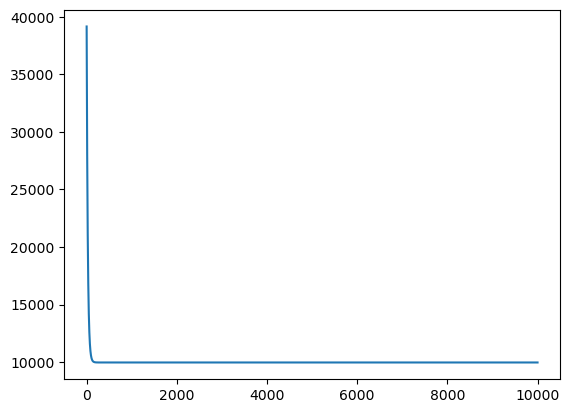

In [154]:
# your code here
plt.plot(cost_track_gd);

In [155]:
# your code for SGD here


## Quiz

Измерьте время работы аналитического подхода, а также GD и SGD (используйте magic command [`%%time`](https://ipython.readthedocs.io/en/stable/interactive/magics.html)).

Упорядочите результаты по возрастанию.

## Тестирование моделей на реальных данных

В реальных задачах никто не пишет методы с нуля, если они уже реализованы в python. Самостоятельная реализация методов полезна для получения навыков программирования и более глубокого понимания алгоритмов.

Давайте применим уже готовые методы из `sklearn` для решения задачи регрессии.

In [156]:
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

Разобъем данные на трейн и тест

In [157]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
    )

Для решения этой задачи попробуйте следующие модели:

* `LinearRegression` из `sklearn`
* `SGDRegressor` из `sklearn`

Обучите модели на тренировочных данных с параметрами по умолчанию и сделайте предсказание на тесте.
Вычислите значение $R^2$

In [158]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
y_pred_linreg = linreg_model.predict(X_train)

sgd_model = SGDRegressor(penalty=None, learning_rate='constant', eta0=0.005, max_iter=100000)
sgd_model.fit(X_train, y_train)
y_pred_sgd = sgd_model.predict(X_train)

In [159]:
print('R^2 linreg : {:.2}'.format(r2_score(y_train, y_pred_linreg)))
print('R^2 SGD : {:.2}'.format(r2_score(y_train, y_pred_sgd)))

R^2 linreg : 0.61
R^2 SGD : -1e+31


In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

## Quiz

Чему равно значение $R^2$ для модели LinearRegression на тестовых данных?

Ответ округлите до сотых.

In [161]:
# ваш код здесь (SGD Regressor)
...

## Quiz

Какая модель с параметрами по умолчанию лучше справилась с предсказанием стоимости домов в Калифорнии?

## Quiz

Проинтерпретируйте качество метода SGDRegressor. Выберите наиболее подходящий вариант.

# 5.1 Классификация

# Бинарные классификаторы

## Импорт библиотек

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Функция потерь

Бинарный линейный классификатор делает предсказание по формуле
$$a(x) = (w,x).$$

А вот функции потерь у разных классификаторов разные.

*  Функция потерь логистической регрессии:

$$
Q_{LR}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle),
$$
где $\sigma(z)=\frac1{1+e^{-z}}$.


Эта функция называется log-loss.

*  Функция потерь метода опорных векторов:

$$
Q_{SVM}(X, w) = C\sum_{i=1}^{l} \max\{0, 1 - y_i(\langle x_i, w\rangle)\} + \|w\|^2 \to \min_w,
$$
где $C$ - гиперпараметр.

Рассмотрим свойства логистической регрессии и метода опорных векторов на примере классического набора данных ["Ирисы Фишера"](https://ru.wikipedia.org/wiki/Ирисы_Фишера). Этот набор состоит из 150 наблюдений, каждое из которых представляет собой четыре измерения: длина наружной доли околоцветника (`sepal length`), ширина наружной доли околоцветника (`sepal width`), длина внутренней доли околоцветника (`petal length`), ширина внутренней доли околоцветника (`petal width`). Каждое наблюдение относится к одному из трёх классов ириса: `setosa`, `versicolor` или `virginica`.

Задача состоит в том, чтобы по измерениям предсказать класс цветка.

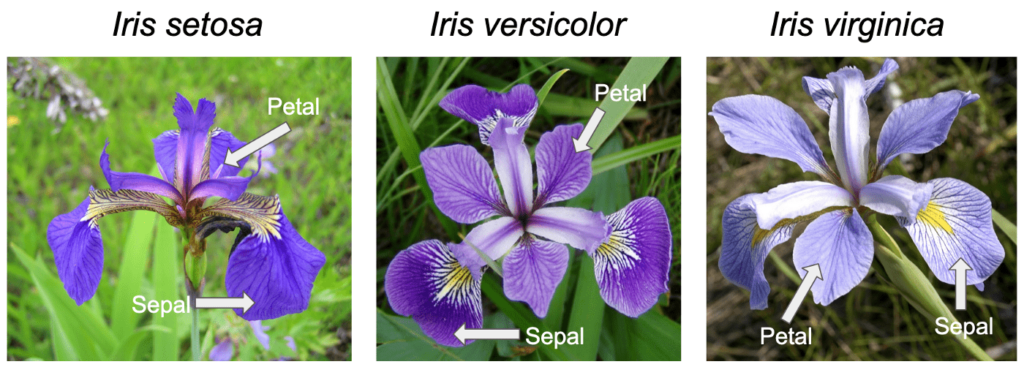

## Обзор данных

In [163]:
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [164]:
set(y)

{np.int64(0), np.int64(1), np.int64(2)}

## Задача

Перейдём к задаче бинарной классификации: будем предсказывать принадлежность цветка к виду `versicolor` против принадлежности ко всем прочим видам. Перекодируем целевую переменную так, чтобы цветки вида `versicolor` имели метку 1, а прочих видов – метку 0.

In [165]:
data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [166]:
y[y != 1] = 0

y[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Наши следующие действия:

*  Будем работать с двумя признаками: `sepal length (cm)` и `sepal width (cm)`. Сделаем из  них в отдельную матрицу.
*  Отмасштабируем выборки при помощи StandardScaler.
*  Построим диаграмму рассеяния по тренировочной выборке и убедимся, что данные линейно не разделимы.

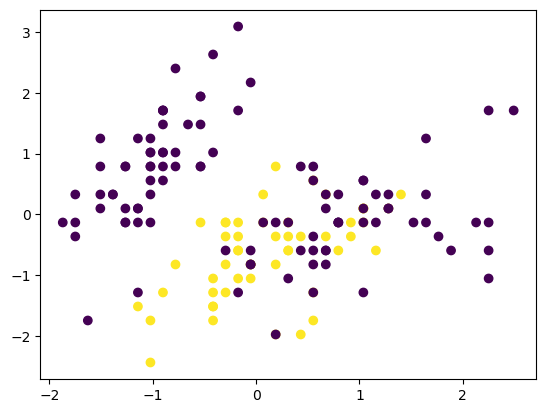

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(123)

X = X[['sepal length (cm)', 'sepal width (cm)']]

ss = StandardScaler()
X = ss.fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c = y);

Обучим логистическую регрессию и метод опорных векторов на тренировочной выборке и убедимся, что полученные веса различаются.

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

lr = LogisticRegression()
lr.fit(X, y)

svm = LinearSVC()
svm.fit(X, y)

print(lr.coef_)
print(svm.coef_)

[[ 0.1033129  -1.29975427]]
[[ 0.02577291 -0.52074853]]


Теперь посмотрим, как различаются решающие поверхности алгоритмов.

Код ниже построит решающие поверхности для классификаторов.

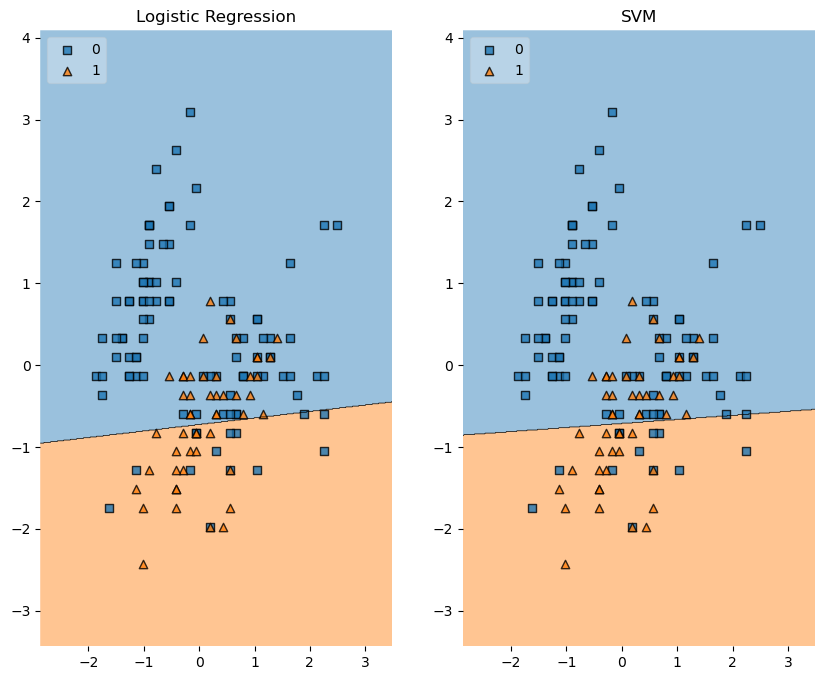

In [169]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(1, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'SVM']
for clf, lab, grd in zip([lr, svm],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=np.array(y), clf=clf, legend=2)
    plt.title(lab)

plt.show();

In [170]:
-np.log2(0.5)

np.float64(1.0)

# 5.2 Логистическая регрессия

Обучим логистическую регрессию для предсказания того, откликнется клиент  
на рекламное предложение (target = 1) или нет (target = 0).

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [172]:
# считаем данные
data = pd.read_csv('data/clients_data.csv')

In [173]:
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


In [174]:
from sklearn.model_selection import train_test_split

X = data.drop('TARGET', axis=1)
y = data['TARGET']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=123)

Обучим логистическую регрессию с параметрами по умолчанию.

In [175]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [176]:
lr.fit(Xtrain, ytrain)

prediction = lr.predict(Xtest)

In [177]:
prediction[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Посмотрим на долю правильных ответов модели.

In [178]:
from sklearn.metrics import accuracy_score

accuracy_score(ytest, prediction)

0.8767243266914824

Теперь предскажем вероятности классов с помощью обученной логистической регрессии на тестовых данных.

In [179]:
probs_test = lr.predict_proba(Xtest)

probs_test[:10]

array([[0.9386005 , 0.0613995 ],
       [0.90059181, 0.09940819],
       [0.710828  , 0.289172  ],
       [0.78458587, 0.21541413],
       [0.87089444, 0.12910556],
       [0.95850941, 0.04149059],
       [0.93632181, 0.06367819],
       [0.9656169 , 0.0343831 ],
       [0.94889185, 0.05110815],
       [0.93091047, 0.06908953]])

У обученной модели можно посмотреть веса (как и в линейной регрессии).  
Выведем на экран веса модели (`model.coef_`, `model.intercept_`).

In [180]:
lr.coef_, lr.intercept_

(array([[-4.61786496e-02, -1.47051152e-01, -8.61124998e-02,
         -1.54075568e-01,  1.91465946e-01, -1.41678351e-01,
          2.01719868e-05, -6.01040000e-02, -2.31268820e-01,
          2.92922789e-01]]),
 array([-0.24167912]))

# Задание по Логистической регрессии

Обучим логистическую регрессию для предсказания того, откликнется клиент  
на рекламное предложение (target = 1) или нет (target = 0).

## Подлючение библиотек, загрузка и обзор данных

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [182]:
data = pd.read_csv('data/clients_data.csv')

In [183]:
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


In [184]:
from sklearn.model_selection import train_test_split

X = data.drop('TARGET', axis=1)
y = data['TARGET']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=123)

## Практика

**Задание**  
Выведите на экран количество объектов каждого класса. Сколько процентов объектов относятся к положительному классу?  
Ответ округлите до целого числа (например, если доля объектов положительного класса равна 0.412, в ответ запишите 41,  
имея в виду 41 процент).

In [185]:
# ваш код здесь
y.value_counts(normalize=True).round(2) * 100

TARGET
0    88.0
1    12.0
Name: proportion, dtype: float64

Обучим логистическую регрессию с параметрами по умолчанию.

In [186]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [187]:
lr.fit(Xtrain, ytrain)

prediction = lr.predict(Xtest)

Метрику accuracy не стоит использовать при сильном дисбалансе классов. Поэтому посчитайте f1_score для оценки качества модели на тестовых данных.

f1_score принимает значения от 0 до 1. Чем ближе к 1, тем лучше модель.

In [188]:
from sklearn.metrics import f1_score

# ваш код здесь
f1_score(ytest, prediction)

0.0

**Вопрос**  
Чему равен `f1_score`?

Удивительно, да?

Давайте разберемся, почему качество такое низкое.

Предскажем вероятности классов с помощью обученной логистической регрессии на тестовых данных.

In [189]:
probs_test = lr.predict_proba(Xtest)

probs_test[:10]

array([[0.9386005 , 0.0613995 ],
       [0.90059181, 0.09940819],
       [0.710828  , 0.289172  ],
       [0.78458587, 0.21541413],
       [0.87089444, 0.12910556],
       [0.95850941, 0.04149059],
       [0.93632181, 0.06367819],
       [0.9656169 , 0.0343831 ],
       [0.94889185, 0.05110815],
       [0.93091047, 0.06908953]])

По вероятностям видно, что вероятности отнесения к положительному классу очень низкие.

Попробуем изменить порог для перевода вероятности в классы.

**Вопрос**  
Чему равен `f1_score`, если все объекты с вероятностью не меньшей 0.1, относить к положительному классу?

Ответ округлите до сотых.

In [190]:
# ваш код здесь
new_prediction = (probs_test[:,1] >= 0.1).astype(int)
round(f1_score(ytest, new_prediction), 2)

0.25

У обученной модели можно посмотреть веса (как и в линейной регрессии).  
Выведем на экран веса модели (`model.coef_`, `model.intercept_`).

In [191]:
lr.coef_, lr.intercept_

(array([[-4.61786496e-02, -1.47051152e-01, -8.61124998e-02,
         -1.54075568e-01,  1.91465946e-01, -1.41678351e-01,
          2.01719868e-05, -6.01040000e-02, -2.31268820e-01,
          2.92922789e-01]]),
 array([-0.24167912]))

Создайте `pd.DataFrame`, где в первом столбце стоят названия признаков, а во втором - их веса (так удобнее анализировать результат).  
Отсортируйте таблицу по убыванию весов.

**Вопрос**  
Какой признак имеет наибольший положительный вес?

In [192]:
# ваш код здесь
coef_df = pd.DataFrame({'features_name': X.columns,
                        'coef': lr.coef_.reshape(-1)})
coef_df.sort_values('coef', ascending=False)

,features_name,coef
9,LOAN_DLQ_NUM,0.292923
4,CHILD_TOTAL,0.191466
6,PERSONAL_INCOME,0.000020
0,AGE,-0.046179
7,LOAN_NUM_TOTAL,-0.060104
2,SOCSTATUS_PENS_FL,-0.086112
5,DEPENDANTS,-0.141678
1,SOCSTATUS_WORK_FL,-0.147051
3,GENDER,-0.154076
8,LOAN_NUM_CLOSED,-0.231269


In [193]:
coef_df = pd.DataFrame({'features_name': X.columns})
coef_df

,features_name
0,AGE
1,SOCSTATUS_WORK_FL
2,SOCSTATUS_PENS_FL
3,GENDER
4,CHILD_TOTAL
5,DEPENDANTS
6,PERSONAL_INCOME
7,LOAN_NUM_TOTAL
8,LOAN_NUM_CLOSED
9,LOAN_DLQ_NUM


## Бонус

**Задание 1**  
Подберите порог для перевода вероятностей в классы, дающий максимальное значение `f1_score`.

In [194]:
# ваш код здесь
thresholds = np.linspace(0, 0.3, 150)
best_threshold = 0
best_f1_score = 0
for threshold in thresholds:
    prediction = (probs_test[:,1] >= threshold).astype(int)
    f1 = f1_score(ytest, prediction)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold
print(f'best_f1_score: {best_f1_score:.5f}, best_threshold : {best_threshold:.5f}')

best_f1_score: 0.26411, best_threshold : 0.10872


**Задание 2**  
Во вложенном цикле подберите одновременно коэффициент регуляризации `C` у логистической регрессии и порог для перевода вероятностей в классы, дающие максимальное значение `f1_score`.

По-хорошему, чтобы не переобучиться, эти величины надо подбирать не по тесту, а по отдельной выборке.

Поэтому разобъем данные изначально на три части: `Xtrain`, `Xval`, `Xtest`.

*   В цикле при подборе `С` и порога будем обучаться по `Xtrain`, а предсказывать и измерять качество по `Xval`.

*   Качество итоговой модели с найденными `C` и порогом измерьте по `Xtest`.

Так не переобучимся!


In [195]:
Xtrain_new, Xval, ytrain_new, yval = train_test_split(Xtrain, ytrain, train_size=0.7, random_state=123)

# ваш код для подбора C и порога здесь

for m in np.arange(1, 100, 10):

    model_ = LogisticRegression(C = m, n_jobs=-1)
    model_.fit(Xtrain_new, ytrain_new)
    probs_ = model_.predict_proba(Xval)
    best_threshold_ = 0
    best_f1_ = 0
    best_c = 0

    for j in probs_[:, 1]:
        predict_ = (probs_[:, 1] > j).astype(int)
        f1_ = f1_score(yval, predict_)
        if f1_ > best_f1_:
            best_f1_score_ = f1_
            best_threshold_ = j   
            best_c = m

print(f'best_f1_score: {best_f1_score_:.5f}, \
      \nbest_threshold : {best_threshold_:.5f} \
      \nbest_c : {best_c}')

best_f1_score: 0.23017,       
best_threshold : 0.07942       
best_c : 91


In [196]:
model = LogisticRegression(C = best_c)

model.fit(Xtrain, ytrain) # обучаемся на всех тренировочных данных

prediction = model.predict_proba(Xtest)

classes = (prediction[:, 1] > best_threshold_).astype(int)

In [197]:
# вычислите значение f1_score на тестовых данных

round(f1_score(ytest, classes), 5)

0.24057

# 5.3 Базовые метрики классификации

In [198]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = 0.2
recall = 0.9

f1 = 2 * precision * recall / (precision + recall)
round(f1, 2)

0.33

# 5.4  Домашнее задание - 4

В этом задании вам предлагается спрогнозировать, купит клиент велосипед или нет, обучив логистическую регрессию.

In [199]:
# подключим библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [200]:
# считаем данные
data = pd.read_csv('data/bike_buyers_clean.csv')

In [201]:
# выводим первые 5 строк датафрейма
data.head(5)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes


In [202]:
# смотрим размер датафрейма
data.shape

(1000, 13)

Выведите статистики по категориальным признакам, чтобы посмотреть, сколько категорий в каждом категориальном (нечисловом) признаке.

Для этого можно воспользоваться методом `describe` из библиотеки pandas со значением параметра `include = 'object'`.

**Вопрос:** в каком категориальном признаке встречаются три различных значения?

In [203]:
# ваш код здесь
data.describe(include='object')

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,Purchased Bike
count,1000,1000,1000,1000,1000,1000,1000,1000
unique,2,2,5,5,2,5,3,2
top,Married,Male,Bachelors,Professional,Yes,0-1 Miles,North America,No
freq,539,509,306,276,685,366,508,519


Закодируйте все категориальные столбцы с двумя категориями следующим образом:  
самая часто встречающаяся категория превращается в 1, другая в 0.

In [204]:
# ваш код здесь
data[[col for col in data.columns if data[col].dtype == 'object']].nunique()

Marital Status      2
Gender              2
Education           5
Occupation          5
Home Owner          2
Commute Distance    5
Region              3
Purchased Bike      2
dtype: int64

In [205]:
cols_binary = [col for col in data.columns if data[col].dtype == 'object' and data[col].nunique() == 2]
data[cols_binary].describe()

,Marital Status,Gender,Home Owner,Purchased Bike
count,1000,1000,1000,1000
unique,2,2,2,2
top,Married,Male,Yes,No
freq,539,509,685,519


In [206]:
for col in cols_binary:
    col_mode = data[col].mode()[0]
    data[col] = data[col].apply(lambda x: (x == col_mode) * 1)

In [207]:
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,1,0,40000,1,Bachelors,Skilled Manual,1,0,0-1 Miles,Europe,42,1
1,24107,1,1,30000,3,Partial College,Clerical,1,1,0-1 Miles,Europe,43,1
2,14177,1,1,80000,5,Partial College,Professional,0,2,2-5 Miles,Europe,60,1
3,24381,0,1,70000,0,Bachelors,Professional,1,1,5-10 Miles,Pacific,41,0
4,25597,0,1,30000,0,Bachelors,Clerical,0,0,0-1 Miles,Europe,36,0


Удалите остальные категориальные столбцы.

**Вопрос:** сколько категориальных столбцов вы удалили?

In [208]:
# ваш код здесь
cols_notbinary = [col for col in data.columns if data[col].dtype == 'object' and data[col].nunique() > 2]
print(cols_notbinary)
data = data.drop(cols_notbinary, axis=1)
data.head()

['Education', 'Occupation', 'Commute Distance', 'Region']


,ID,Marital Status,Gender,Income,Children,Home Owner,Cars,Age,Purchased Bike
0,12496,1,0,40000,1,1,0,42,1
1,24107,1,1,30000,3,1,1,43,1
2,14177,1,1,80000,5,0,2,60,1
3,24381,0,1,70000,0,1,1,41,0
4,25597,0,1,30000,0,0,0,36,0


Удалите столбец `ID`, так как он по сути нечисловой.

In [209]:
# ваш код здесь
data = data.drop('ID', axis=1)
data.head()

,Marital Status,Gender,Income,Children,Home Owner,Cars,Age,Purchased Bike
0,1,0,40000,1,1,0,42,1
1,1,1,30000,3,1,1,43,1
2,1,1,80000,5,0,2,60,1
3,0,1,70000,0,1,1,41,0
4,0,1,30000,0,0,0,36,0


Сформируйте матрицу объект-признак `X` и вектор `y` с целевой переменной.  
Целевая переменная - это последний столбец, `Purchased Bike`.

In [210]:
# ваш код здесь
X = data.drop('Purchased Bike', axis=1)
y = data['Purchased Bike']

Разбейте данные на тренировочную и тестовую часть (`Xtrain`, `Xtest`, `ytrain`, `ytest`), в тест отправьте 30% данных.  
Зафиксируйте `random_state = 42`.

In [211]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

**Вопрос:** сколько объектов в матрице `Xtrain`?

In [212]:
# ваш код здесь
Xtrain.shape

(700, 7)

Почти всё готово для обучения модели!

Осталось отмасштабировать матрицу `X`, так как линейные модели чувствительны к масштабу данных.

*  Обучите на тренировочной матрице (`Xtrain`) `MinMaxScaler` из библиотеки `sklearn.preprocessing`
*  Примените масштабирование и к `Xtrain`, и к `Xtest`
*  Переведите полученные после масштабирования `np.array` обратно в pandas `dataframe`.

Полученные масштабированные матрицы назовите, как и раньше, `Xtrain` и `Xtest`.

In [213]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(Xtrain)

Xtrain_scaled = scaler.transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

Xtrain = pd.DataFrame(Xtrain_scaled, columns=Xtrain.columns)
Xtest = pd.DataFrame(Xtest_scaled, columns=Xtest.columns)

In [214]:
Xtrain.head()

,Marital Status,Gender,Income,Children,Home Owner,Cars,Age
0,1.0,1.0,0.2500,0.2,1.0,0.00,0.140625
1,0.0,1.0,0.5000,0.0,0.0,0.75,0.140625
2,0.0,1.0,0.1875,0.0,0.0,0.00,0.171875
3,0.0,1.0,0.6250,0.0,0.0,0.75,0.109375
4,1.0,1.0,0.5000,1.0,1.0,0.75,0.250000


Теперь обучите логистическую регрессию на тренировочных данных

In [215]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(Xtrain, ytrain)

LogisticRegression()

Сделайте предсказания на тренировочных и на тестовых данных.

In [216]:
# ваш код здесь
ypred = logreg.predict(Xtest)

Оцените значение accuracy на трейне и на тесте.

In [217]:
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(ytest, ypred)
round(acc_score, 2)

0.58

Качество модели получилось невысоким, зато модель не переобучена.

Попробуем добавить новых признаков в модель, используя [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

Создайте полиномиальные признаки degree = 2.

Как обычно:
*  `fit` делайте на тренировочных данных
*  `transform` и на тренировочных, и на тестовых данных. Затем верните результат к формату pandas `dataframe`.

Полученные матрицы назовите, как и раньше, `Xtrain` и `Xtest`.

In [218]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)

pf.fit(Xtrain)

Xtrain_pf = pf.transform(Xtrain)
Xtest_pf = pf.transform(Xtest)

cols_pf = pf.get_feature_names_out(Xtrain.columns)

Xtrain_pf = pd.DataFrame(Xtrain_pf, columns=cols_pf)
Xtest_pf = pd.DataFrame(Xtest_pf, columns=cols_pf)

In [219]:
Xtrain_pf.head()

,1,Marital Status,Gender,Income,Children,Home Owner,Cars,Age,Marital Status^2,Marital Status Gender,...,Children^2,Children Home Owner,Children Cars,Children Age,Home Owner^2,Home Owner Cars,Home Owner Age,Cars^2,Cars Age,Age^2
0,1.0,1.0,1.0,0.2500,0.2,1.0,0.00,0.140625,1.0,1.0,...,0.04,0.2,0.00,0.028125,1.0,0.00,0.140625,0.0000,0.000000,0.019775
1,1.0,0.0,1.0,0.5000,0.0,0.0,0.75,0.140625,0.0,0.0,...,0.00,0.0,0.00,0.000000,0.0,0.00,0.000000,0.5625,0.105469,0.019775
2,1.0,0.0,1.0,0.1875,0.0,0.0,0.00,0.171875,0.0,0.0,...,0.00,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0000,0.000000,0.029541
3,1.0,0.0,1.0,0.6250,0.0,0.0,0.75,0.109375,0.0,0.0,...,0.00,0.0,0.00,0.000000,0.0,0.00,0.000000,0.5625,0.082031,0.011963
4,1.0,1.0,1.0,0.5000,1.0,1.0,0.75,0.250000,1.0,1.0,...,1.00,1.0,0.75,0.250000,1.0,0.75,0.250000,0.5625,0.187500,0.062500


In [220]:
Xtrain_pf.shape[1] - Xtrain.shape[1]

29

**Вопрос:** на сколько признаков стало больше при добавлении полиномиальных признаков второй степени?

Заново обучите логистическую регрессию, уже на расширенной матрице признаков, и сделайте предсказания на трейне и тесте, а затем оцените качество (*accuracy*).

In [221]:
# ваш код здесь
logreg.fit(Xtrain_pf, ytrain)
ypred = logreg.predict(Xtest_pf)

acc_score_pf = accuracy_score(ytest, ypred)
round(acc_score_pf, 2)

0.62

**Вопрос:** на сколько повысилось качество модели на тестовых данных?  
Ответ округлите до сотых.

In [222]:
round(acc_score_pf - acc_score, 2)

0.05

Появились новые требования от заказчика!

Заказчик просит, чтобы:
*  доля найденных моделью потенциальных покупателей была максимальной
*  accuracy при этом была не ниже, чем 0.6 (отклонения *accuracy* на тестовых данных на $\pm 0.05$ допустимы).

Сначала посмотрите, какие значения *recall* и *accuracy* имеют предсказния модели на тесте с классами, предсказанными по умолчанию (методом `predict`).

In [223]:
# ваш код здесь
acc_score_pf = accuracy_score(ytest, ypred)
print(acc_score_pf)

recall_pf = recall_score(ytest, ypred)
print(recall_pf)

0.6233333333333333
0.6959459459459459


Подберём порог для перевода вероятностей в классы, чтобы оптимизировать требуемые метрики!

Разобъем тренировочные данные на трейн и валидацию, чтобы по валидационной части подбирать порог.

In [224]:
XtrainS, Xval, ytrainS, yval = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)

XtrainS.shape, Xval.shape

((490, 7), (210, 7))

* Обучите модель на тренировочных данных.
* Предскажите вероятности положительного класса на валидационных данных

В цикле для каждого значения порога:
*  переведите вероятности в классы
*  вычислите полноту (на валидационных данных)

Выведите на экран:

1) значение порога, дающее максимальный *recall*, при условии, что *accuracy* $\geq$ 0.6.

2) значение *recall* при этом пороге

3) значение *accuracy* для этого порога


Ищите порог на отрезке от 0 до 1 с шагом 0.01.

In [225]:
logreg = LogisticRegression()

logreg.fit(XtrainS, ytrainS)
probs_val = logreg.predict_proba(Xval)

In [226]:
from sklearn.metrics import recall_score

RecMax = -1
BestThr = -1
BestAcc = -1

for thr in np.arange(0, 1, 0.01):
    prediction = (probs_val[:,1] >= thr).astype(int)
    acc_score = accuracy_score(yval, prediction)
    if acc_score >= 0.6:
        recall = recall_score(yval, prediction)
        if recall > RecMax:
            RecMax = recall
            BestThr = thr
            BestAcc = acc_score
print(f'RecMax  : {RecMax:.5f}\n\
BestThr : {BestThr:.5f}\n\
BestAcc : {BestAcc:.5f}\n')

print (BestThr, RecMax, BestAcc)

RecMax  : 0.82407
BestThr : 0.43000
BestAcc : 0.60000

0.43 0.8240740740740741 0.6


Теперь заново обучите модель на исходных тренировочных данных (`Xtrain`, `ytrain`), предскажите вероятности на тесте и переведите их в классы по найденному порогу.

In [227]:
# ваш код здесь

logreg.fit(Xtrain_pf, ytrain)
probs = logreg.predict_proba(Xtest_pf)
classes_pred = (probs[:, 1] >= BestThr).astype(int)

recall = recall_score(ytest, classes_pred)
round(recall, 1)

0.8

**Вопрос:** какое значение *recall* получилось на тестовых данных после подбора порога?  
Ответ округлите до десятых.

При помощи подбора порога удалось сильно увеличить значение *recall*!  
Однако, как видно, на тесте не удалось сохранить условие $accuracy \geq 0.6$ (но в допустимые рамки уложились!)

Это свидетельство небольшого переобучения модели. Однако в сухом остатке имеет значительное увеличение полноты, что является приоритетом для заказчика.

# 6.1, 6.2 Работа с пропусками и Нормализация данных

In [228]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [229]:
df = pd.read_csv("data/titanik2.csv", delimiter=';')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund; Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen; Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen; Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


Посмотрим на количество пропусков в столбцах

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 1. Вспомогательные преобразования

* Переведем пол в 0 и 1

In [231]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

* Выкинем столбец `PassengerId`, так как он не несет полезной информации

* Также выкинем столбец `Name` - в рамках этого скринкаста также не будем его использовать

In [232]:
df.drop(['PassengerId','Name'],axis=1,inplace=True)

* Выкинем столбец `Ticket`, так как это аналог id пассажира - у каждого билета уникальный номер

* Также ***выкинем столбец `Cabin`, так как в нем очень много пропущенных значений (первая стратегия)***

In [233]:
df.drop(['Ticket','Cabin'],axis=1,inplace=True)

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


Осталось два столбца с пропусками - `Age` и `Embarked`.

***В столбце `Embarked` всего два пропущенных значения - выкинем строки с этими значениями (вторая стратегия).***

In [235]:
df = df[df['Embarked'].notna()]

Остался столбец `Age` - он представляет наибольший интерес, так как в нем достаточно много пропусков, но и удалять его неразумно.

Далее посмотрим на различные стратегии заполнения пропусков в этом столбце. Будем заполнять пропуски и смотреть как это отражается на качестве модели.

In [236]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


## 2. Кодирование категориальных признаков и масштабирование

Признак `Embarked` может быть полезен, поэтому закодируем его при помощи OneHot encoding.

In [237]:
df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [238]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,True
1,1,1,0,38.0,1,0,71.2833,False,False
2,1,3,0,26.0,0,0,7.9250,False,True
3,1,1,0,35.0,1,0,53.1000,False,True
4,0,3,1,35.0,0,0,8.0500,False,True


Мы будем обучать линейные модели, поэтому данные важно ***масштабировать***.

Так как после OHE получились столбцы со значениями 0 и 1, применим для нормализации данных MinMaxScaler, чтобы все значения признаков лежали на отрезке от 0 до 1 (но можно применить и StandardScaler).

In [239]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.014151,0.0,1.0
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0,0.0
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469,0.0,1.0
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.103644,0.0,1.0
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.015713,0.0,1.0


## 3. Заполнение пропусков в столбце `Age`

* ***Заполним пропуски в столбце `Age` средним значением, но можно еще заполнять медианой (третья стратегия)***

In [240]:
updated_df = df.copy()
updated_df['Age'] = updated_df['Age'].fillna(updated_df['Age'].mean())

In [241]:
X = updated_df.drop('Survived', axis=1)
y = updated_df['Survived']

cv = KFold(n_splits=3, random_state=42, shuffle=True)

cross_val_score(LogisticRegression(), X, y, cv=cv).mean()

np.float64(0.7997732581065914)

***Используем машинное обучение для предсказания пропущенных значений (четвертая стратегия)***

In [242]:
from sklearn.linear_model import LinearRegression

df_numeric = df.copy()

test_df = df_numeric[df_numeric['Age'].isnull() == True]
train_df = df_numeric[df_numeric['Age'].isnull() == False]
y = train_df['Age']

train_df.drop(['Age','Survived'], axis=1, inplace=True)
test_df.drop(['Age','Survived'], axis=1, inplace=True)

In [243]:
lr = LinearRegression()

lr.fit(train_df, y)

pred = lr.predict(test_df)

In [244]:
updated_df2 = df.copy()

indices = test_df.index.to_numpy()

updated_df2.loc[indices, 'Age'] = pred

In [245]:
updated_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    float64
 1   Pclass      889 non-null    float64
 2   Sex         889 non-null    float64
 3   Age         889 non-null    float64
 4   SibSp       889 non-null    float64
 5   Parch       889 non-null    float64
 6   Fare        889 non-null    float64
 7   Embarked_Q  889 non-null    float64
 8   Embarked_S  889 non-null    float64
dtypes: float64(9)
memory usage: 62.6 KB


In [246]:
X = updated_df2.drop('Survived', axis=1)
y = updated_df2['Survived']

cross_val_score(LogisticRegression(), X, y, cv=cv).mean()

np.float64(0.7975210058543393)

# 6.3 Кодирование категориальных признаков

## Задача бинарной классификации

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [248]:
data = pd.read_csv('data/bike_buyers_clean2.csv')

In [249]:
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes


# Обзор данных

In [250]:
# проверим типы колонок в датасете
data.dtypes

ID                   int64
Marital Status      object
Gender              object
Income               int64
Children             int64
Education           object
Occupation          object
Home Owner          object
Cars                 int64
Commute Distance    object
Region              object
Age                  int64
Purchased Bike      object
dtype: object

In [251]:
X = data.iloc[:,:-1]
X.drop(columns='ID', inplace=True)

y = data['Purchased Bike'].map({'Yes' : 1, 'No' : 0})

In [252]:
num_cols = X.columns[X.dtypes == 'int64'].tolist()
cat_cols = X.columns[X.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 4 numeric columns: Income, Children, Cars, Age
And 7 categorical columns: Marital Status, Gender, Education, Occupation, Home Owner, Commute Distance, Region


In [253]:
# у нас есть категориальные переменные разных видов!

binary_cols = cat_cols[X[cat_cols].nunique() == 2].tolist()
ordinal_cols = ['Commute Distance', 'Education']
cat_cols = cat_cols.difference(binary_cols + ordinal_cols).tolist()

## Кодирование категориальных признаков

In [254]:
from category_encoders.ordinal import OrdinalEncoder # LabelEncoder
from category_encoders.one_hot import OneHotEncoder # OneHotEncoding
from category_encoders.target_encoder import TargetEncoder # счетчики+сглаживание
from category_encoders.leave_one_out import LeaveOneOutEncoder # счетчики по LOO-кросс-валидации

In [255]:
# Ordinal: from categories to numbers

ord_enc = OrdinalEncoder()
ord_enc.fit_transform(X['Education'])

,Education
0,1
1,2
2,2
3,1
4,1
...,...
995,3
996,5
997,1
998,1


In [256]:
# One hot: from k categories to k dummy columns

one_hot_enc = OneHotEncoder()

one_hot_enc.fit_transform(X['Education'], Evgeny=1, Elena=0)
# * fit -> определить количество новых столбцов (по кол-ву категорий)
# * transform -> создать новые столбцы
# * fit_transform = fit + transform

,Education_1,Education_2,Education_3,Education_4,Education_5
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
995,0,0,1,0,0
996,0,0,0,0,1
997,1,0,0,0,0
998,1,0,0,0,0


Target encoding вычисляет значения по формуле

$$\frac{mean(target)\cdot n_{rows} + \alpha \cdot globalMean}{n_{rows} + \alpha} $$

In [257]:
tgt_enc = TargetEncoder(smoothing=1)

# smoothing - это коэффициент сглаживания alpha, чем он больше, тем больше регуляризация

tgt_enc.fit_transform(X['Education'], y)

,Education
0,0.552288
1,0.449057
2,0.449057
3,0.552288
4,0.552288
...,...
995,0.441341
996,0.540230
997,0.552288
998,0.552288


In [258]:
loo_enc = LeaveOneOutEncoder(sigma=0.3)

loo_enc.fit_transform(X['Education'], y)

,Education
0,0.459412
1,0.680081
2,0.600978
3,0.710711
4,0.802218
...,...
995,0.384633
996,0.693158
997,0.608477
998,0.630750


In [259]:
# энкодер можно применять сразу на весь датафрейм

tgt_enc = TargetEncoder(cols=['Education', 'Gender', 'Region'])
tgt_enc.fit_transform(X, y)

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,Married,0.486762,40000,1,0.552288,Skilled Manual,Yes,0,0-1 Miles,0.493333,42
1,Married,0.475442,30000,3,0.449057,Clerical,Yes,1,0-1 Miles,0.493333,43
2,Married,0.475442,80000,5,0.449057,Professional,No,2,2-5 Miles,0.493333,60
3,Single,0.475442,70000,0,0.552288,Professional,Yes,1,5-10 Miles,0.588542,41
4,Single,0.475442,30000,0,0.552288,Clerical,No,0,0-1 Miles,0.493333,36
...,...,...,...,...,...,...,...,...,...,...,...
995,Married,0.475442,60000,2,0.441341,Professional,Yes,2,2-5 Miles,0.433071,54
996,Single,0.475442,70000,4,0.540230,Professional,Yes,0,2-5 Miles,0.433071,35
997,Married,0.475442,60000,2,0.552288,Skilled Manual,Yes,0,0-1 Miles,0.433071,38
998,Single,0.475442,100000,3,0.552288,Management,No,3,1-2 Miles,0.433071,38


Правильный способ преобразований признаков (масштабирование, кодирование и так далее):
* обучаем преобразование на тренировочных данных
* применяем преобразование и к трейну, и к тесту

In [260]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [261]:
tgt_enc = TargetEncoder(cols=['Education', 'Gender', 'Region'])

tgt_enc.fit(Xtrain, ytrain)

Xtrain_new = tgt_enc.transform(Xtrain)
Xtest_new = tgt_enc.transform(Xtest)